### Basic analysis of naturally occurring mutations on IAV-NA
### To do: ehhhh.....

In [271]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss
from Bio import SeqIO
from Bio.Seq import Seq
import seaborn as sns
import matplotlib
from matplotlib import colors
from matplotlib import cm
import dnds
from collections import Counter
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [81]:
seqdict = {}
infile = open('result/database/aligned_database_WSN_NA.fasta')
for record in SeqIO.parse(infile,'fasta'):
    seqdict[str(record.description)] = str(record.seq)
infile.close()
print(len(seqdict))

19137


In [82]:
refseq = seqdict['WSN_NA']
refaa = refseq.replace('-','')
refaa

'MNPNQKIITIGSICMVVGIISLILQIGNIISIWISHSIQTGNQNHTGICNQGSITYKVVAGQDSTSVILTGNSSLCPIRGWAIHSKDNGIRIGSKGDVFVIREPFISCSHLECRTFFLTQGALLNDKHSRGTFKDRSPYRALMSCPVGEAPSPYNSRFESVAWSASACHDGMGWLTIGISGPDDGAVAVLKYNRIITETIKSWRKNILRTQESECTCVNGSCFTIMTDGPSDGLASYKIFKIEKGKVTKSIELNAPNSHYEECSCYPDTGKVMCVCRDNWHGSNRPWVSFDQNLDYKIGYICSGVFGDNPRPKDGTGSCGPVSADGANGVKGFSYKYGNGVWIGRTKSDSSRHGFEMIWDPNGWTETDSRFSMRQDVVAITNRSGYSGSFVQHPELTGLDCMRPCFWVELIRGLPEEDAIWTSGSIISFCGVNSDTVDWSWPDGAELPFTIDK'

Nice

In [5]:
fitdata = pd.read_csv('YS_input/RF_W_Raw_Update',sep='\t')
fitdata

,Pos,Genotype,Frame1,Frame2,PLASMID(reads/WT),RF_OS,RF_ZA,RF_PE,RF_CTRL,W_OS,W_ZA,W_PE
0,1062,A1062C,R352R,X0X,0.000201,0.174898,0.389618,0.271279,1.418964,0.123257256,0.274579228,0.191180768
1,1176,T1176G,F390V,X0X,0.000201,0.043724,0.033880,0.020868,0.045407,0.962947313,0.746139206,0.459569154
2,1163,G1163T,G385G,X0X,0.000201,2.812936,0.279509,0.229543,0.397310,7.079955484,0.70350268,0.57774408
3,1034,G1034C,W342C,X0X,0.000201,0.029150,0.008470,0.014413,0.068110,0.427976584,0.124356534,0.21161634
4,1052,T1052G,S348R,X0X,0.000201,0.109311,0.169399,0.657329,0.170276,0.641964875,0.994852275,3.860380896
...,...,...,...,...,...,...,...,...,...,...,...,...
2641,960,A960G,S318G,X0X,0.008578,0.041641,0.085224,0.028699,0.113354,0.367350245,0.751838408,0.253184499
2642,137,A137G,Q43Q,X0X,0.008786,0.659450,0.841977,1.424187,0.841684,0.783488517,1.000347655,1.692067777
2643,206,A206G,S66S,X0X,0.009046,1.323510,0.291321,1.242907,0.796299,1.662077604,0.365843823,1.560855446
2644,803,T803A,C265_,X0X,0.009403,0.001310,0.002719,0.001671,0.007070,0.185295352,0.384661511,0.236300593


Let me see how good is fitness data

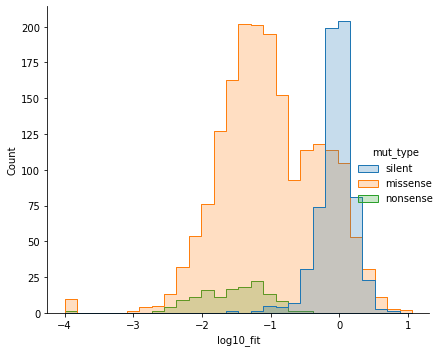

In [6]:
def find_muttype(mut):
    if mut[-1] == mut[0]:
        return 'silent'
    if mut[-1] == '_':
        return 'nonsense'
    return 'missense'

fitdata['mut_type'] = fitdata['Frame1'].apply(lambda x:find_muttype(x))
fitdata['log10_fit'] = np.log10(fitdata['RF_CTRL']+1e-4)
sns.displot(fitdata, x="log10_fit", hue="mut_type", element="step")
plt.tight_layout()

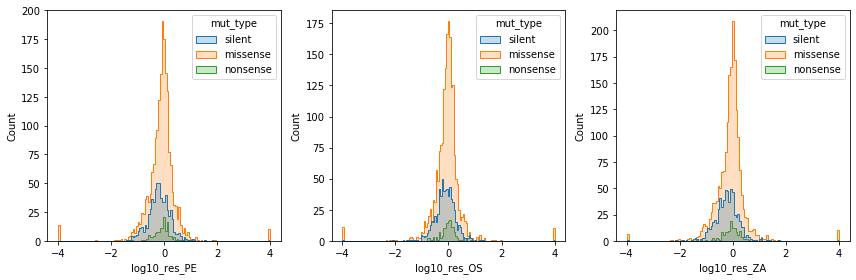

In [7]:
def res_mean(x,drug):
    meandrugfit = x['RF_'+drug]
    fit = x['RF_CTRL']
    if fit == 0:
        return 4
    else:
        return np.log10(meandrugfit/fit+1e-4)

druglist = ['PE','OS','ZA']
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    fitdata['log10_res_'+drug] = fitdata.apply(lambda x:res_mean(x,drug),axis=1)
    sns.histplot(fitdata, x='log10_res_'+drug, hue="mut_type", element="step",ax=ax)
plt.tight_layout()

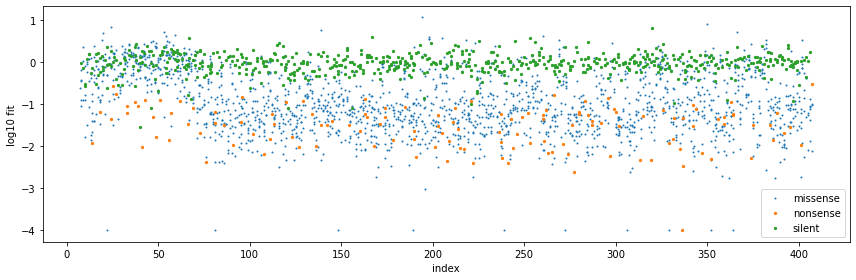

In [8]:
fitdata['aapos'] = fitdata['Frame1'].apply(lambda x:int(x[1:-1]))
plt.figure(figsize=(12,4))
plt.xlabel('index')
plt.ylabel('log10 fit')
plt.scatter(fitdata[fitdata['mut_type']=='missense']['aapos'],fitdata[fitdata['mut_type']=='missense']['log10_fit'],s=1,label='missense')
plt.scatter(fitdata[fitdata['mut_type']=='nonsense']['aapos'],fitdata[fitdata['mut_type']=='nonsense']['log10_fit'],s=5,label='nonsense')
plt.scatter(fitdata[fitdata['mut_type']=='silent']['aapos'],fitdata[fitdata['mut_type']=='silent']['log10_fit'],s=5,label='silent')
plt.legend()
plt.tight_layout()

Weird NTD

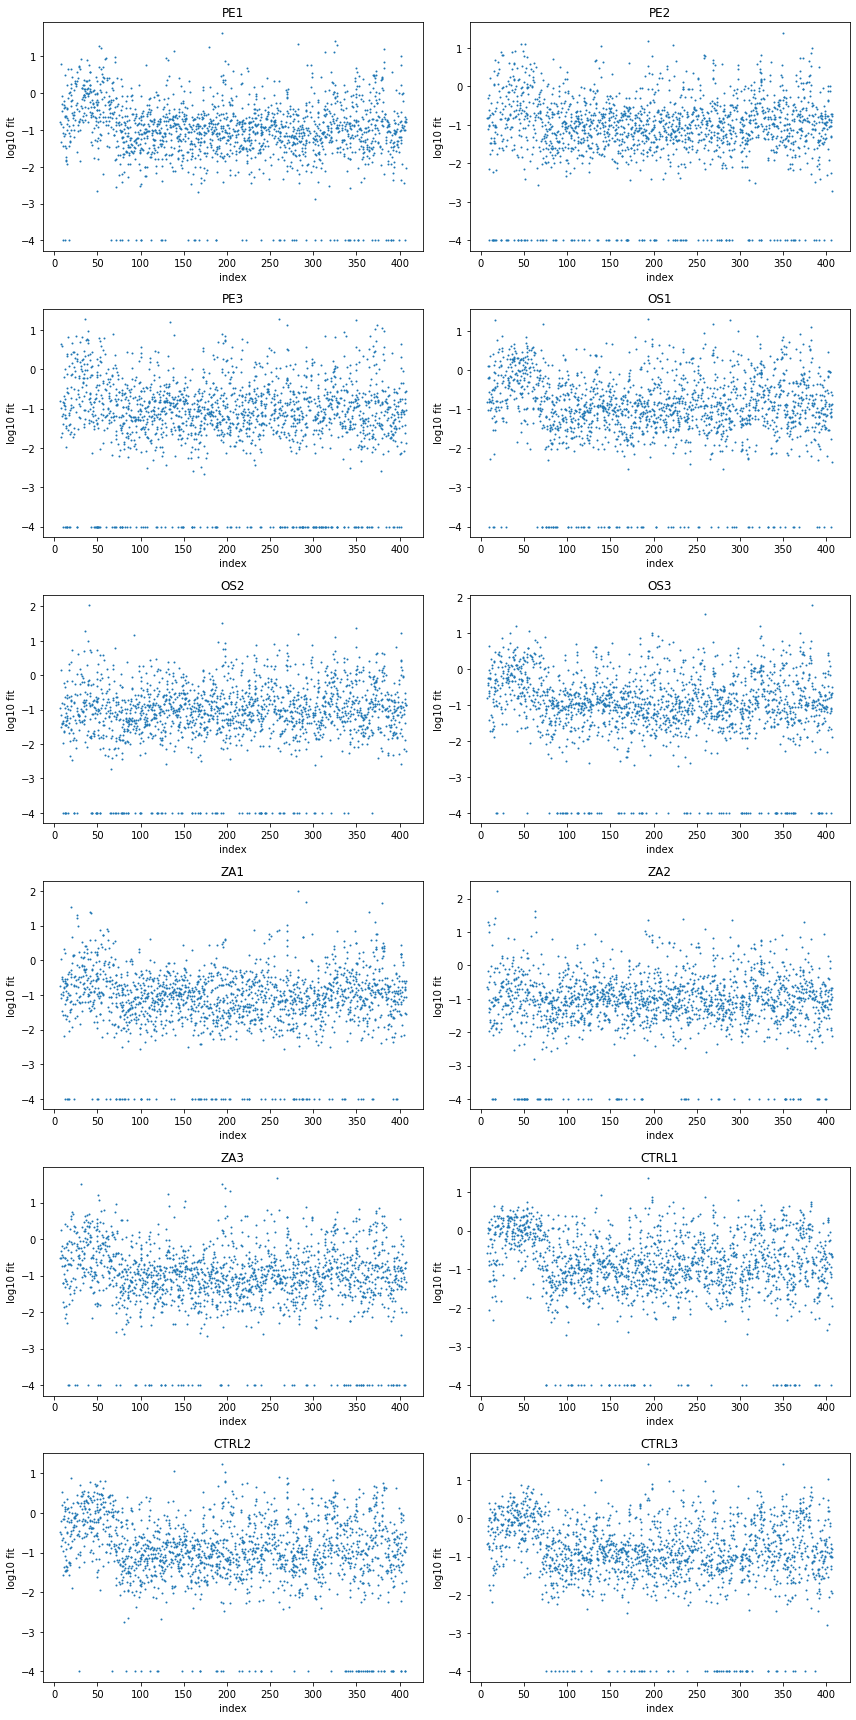

In [16]:
#not applicable for this batch 07-01-2021
ploti = 0
plt.figure(figsize=(12,24))
for drug in druglist+['CTRL']:
    for rep in range(1,4):
        ploti += 1
        plt.subplot(6,2,ploti)
        plt.scatter(fitdata[fitdata['mut_type']=='missense']['aapos'],np.log10(fitdata[fitdata['mut_type']=='missense']['fit'+drug+str(rep)]+1e-4),s=1)
        plt.xlabel('index')
        plt.ylabel('log10 fit')
        plt.title(drug+str(rep))
plt.tight_layout()

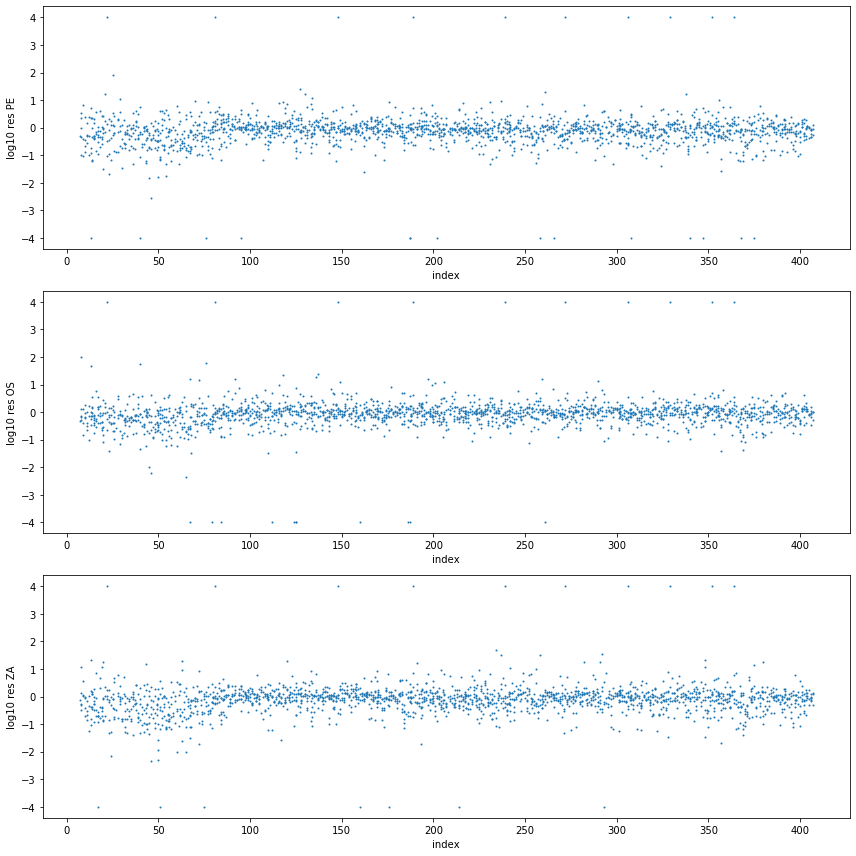

In [9]:
plt.figure(figsize=(12,12))
ploti = 0
for drug in druglist:
    ploti += 1
    plt.subplot(3,1,ploti)
    plt.xlabel('index')
    plt.ylabel('log10 res '+drug)
    plt.scatter(fitdata[fitdata['mut_type']=='missense']['aapos'],fitdata[fitdata['mut_type']=='missense']['log10_res_'+drug],s=1)
plt.tight_layout()

NTD is only a no drug problem. Maybe need to look into specific replicate.

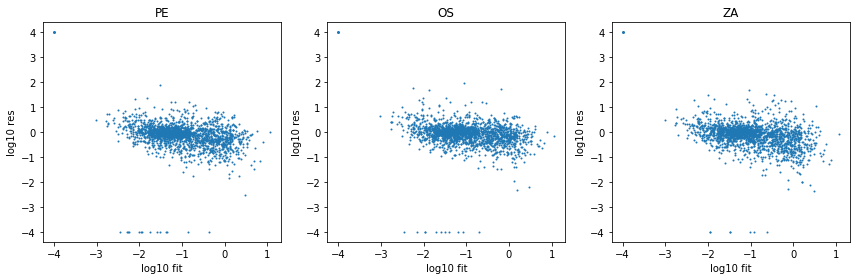

In [10]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    plt.subplot(1,3,ploti)
    plt.scatter(fitdata[fitdata['mut_type']=='missense']['log10_fit'],fitdata[fitdata['mut_type']=='missense']['log10_res_'+drug],s=1)
    plt.title(drug)
    plt.xlabel('log10 fit')
    plt.ylabel('log10 res')
plt.tight_layout()

Let's calculate fitness for all NOS

In [11]:
aaposlist = range(7,408)
aalist = list('RKDEHSTNQCGPAILMFWYV*')
smutlist = []; saaposlist = []; submutlist = []
for aapos in aaposlist:
    for aa in aalist:
        smutlist.append(refaa[aapos-1]+str(aapos)+aa)
        saaposlist.append(aapos)
        submutlist.append(aa)
sdata = pd.DataFrame(data={'mutation':smutlist,'aapos':saaposlist,'substituion':submutlist})
sdata

,mutation,aapos,substituion
0,I7R,7,R
1,I7K,7,K
2,I7D,7,D
3,I7E,7,E
4,I7H,7,H
...,...,...,...
8416,W407F,407,F
8417,W407W,407,W
8418,W407Y,407,Y
8419,W407V,407,V


In [12]:
def mean_me(mutation):
    tmpdata = fitdata[(fitdata['aapos']==int(mutation[1:-1]))]
    if mutation[0] == mutation[-1]:
        tmpdata = tmpdata[tmpdata['mut_type']=='silent']
    elif mutation[-1] == '*':
        tmpdata = tmpdata[tmpdata['mut_type']=='nonsense']
    else:
        tmpdata = tmpdata[tmpdata['Frame1']==mutation]
    if len(tmpdata) == 0:
        return 0
    else:
        return np.mean([x if x > -3 else -3 for x in list(tmpdata['log10_fit']) ])
    
sdata['mutational effect'] = sdata['mutation'].apply(lambda x:mean_me(x))
sdata 

,mutation,aapos,substituion,mutational effect
0,I7R,7,R,0.000000
1,I7K,7,K,0.000000
2,I7D,7,D,0.000000
3,I7E,7,E,0.000000
4,I7H,7,H,0.000000
...,...,...,...,...
8416,W407F,407,F,0.000000
8417,W407W,407,W,0.000000
8418,W407Y,407,Y,0.000000
8419,W407V,407,V,0.000000


In [13]:
def mean_res(mutation,drug):
    tmpdata = fitdata[(fitdata['aapos']==int(mutation[1:-1]))]
    if mutation[0] == mutation[-1]:
        tmpdata = tmpdata[tmpdata['mut_type']=='silent']
    elif mutation[-1] == '*':
        tmpdata = tmpdata[tmpdata['mut_type']=='nonsense']
    else:
        tmpdata = tmpdata[tmpdata['Frame1']==mutation]
    if len(tmpdata) == 0:
        return 0
    else:
        return np.mean([x if x > -4 else -4 for x in list(tmpdata['log10_res_'+drug]) ])

for drug in druglist:
    sdata['log10_'+drug+'_res'] = sdata['mutation'].apply(lambda x:mean_res(x,drug))
    #sdata = sdata[sdata['mutational effect']!=0]
sdata 

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res
0,I7R,7,R,0.000000,0.000000,0.000000,0.000000
1,I7K,7,K,0.000000,0.000000,0.000000,0.000000
2,I7D,7,D,0.000000,0.000000,0.000000,0.000000
3,I7E,7,E,0.000000,0.000000,0.000000,0.000000
4,I7H,7,H,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
8416,W407F,407,F,0.000000,0.000000,0.000000,0.000000
8417,W407W,407,W,0.000000,0.000000,0.000000,0.000000
8418,W407Y,407,Y,0.000000,0.000000,0.000000,0.000000
8419,W407V,407,V,0.000000,0.000000,0.000000,0.000000


In [15]:
#legacy codes, these files contains insufficient data
'''
seqdict = {}
for year in range(2000,2021):
    infile = open('YS_input/database_aligned_sequences/aligned_WSN_database'+str(year)+'.fasta')
    for record in SeqIO.parse(infile,'fasta'):
        seqdict[str(year)+str(record.description)] = str(record.seq)
    infile.close()
print(len(seqdict))
refseqs = {}
for year in range(2000,2021):
    refseqs[year] = seqdict[str(year)+'WSN_NA']
'''

20160


In [83]:
count = 0
for seqname in seqdict:
    print(seqname.rsplit('|')[4].rsplit('/')[-1])
    count += 1
    if count == 50: break

2016
2010
2016
2018
2013
2012
2012
2014
2013
2014
2014
2013
2012
2014
2013
2013
2013
2017
2018
2017
2017
2017
2016
2017
2016
2016
2017
2016
2013
2013
2013
2013
2013
2013
2013
2013
2012
2017
2012
2012
2014
2014
2014
2014
2013
2014
2014
2014
2013
2013


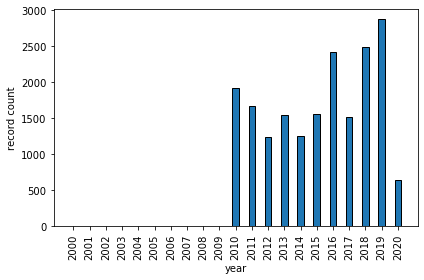

In [92]:
countbyyear = {}
for year in range(2000,2021):
    countbyyear[year] = 0
for seqname in seqdict:
    try:
        year = float(seqname.rsplit('|')[4].rsplit('/')[-1][:4])
        countbyyear[year] += 1
    except:
        continue
plt.figure(figsize=(6,4))
plt.bar(x=range(2000,2021),height=countbyyear.values(),width=0.4,edgecolor='black')
plt.xticks(range(2000,2021),rotation=90)
plt.xlabel('year')
plt.ylabel('record count')
plt.tight_layout()
plt.savefig('record_count_by_year.png',dpi=600)

In [282]:
datelist = []
inferfitlist = []
seqlist = []
nmutlist = []
countrylist = []
reslist = {}
for drug in druglist:
    reslist[drug] = []
count = 0
for seqname in seqdict:
    if count % 1000 == 0:
        print('reading reference count: '+str(count)+'\nDated sequence: '+str(len(datelist)))
    count += 1
    seq = seqdict[seqname]
    aaseq = ''
    try:
        year = float(seqname.rsplit('|')[4].rsplit('/')[-1][:4])
        country = seqname.rsplit('|')[4].rsplit('/')[-3]
    except:
        continue
    for i,aa in enumerate(seq):
        if refseq[i] == '-': continue
        else:
            aaseq += aa
    if len(refaa) != len(aaseq): 
        continue
    fit = 0
    nmut = 0
    pe = 0
    za = 0
    os = 0
    for i in range(len(refaa)):
        if refaa[i] != aaseq[i]:
            nmut += 1
            qmut = refaa[i]+str(i+1)+aaseq[i]
            sfit = sdata[sdata['mutation']==qmut]['mutational effect']
            if len(sfit) == 0:
                continue
            fit += sum(sfit)
            pe += sum(sdata[sdata['mutation']==qmut]['log10_PE_res'])
            za += sum(sdata[sdata['mutation']==qmut]['log10_ZA_res'])
            os += sum(sdata[sdata['mutation']==qmut]['log10_OS_res'])
    inferfitlist.append(fit)
    seqlist.append(aaseq)
    nmutlist.append(nmut)
    datelist.append(float(year))
    countrylist.append(country)
    reslist['PE'].append(pe)
    reslist['ZA'].append(za)
    reslist['OS'].append(os)
print('all sequences: '+str(len(datelist)))
naturedata = pd.DataFrame(list(zip(seqlist, inferfitlist, datelist, nmutlist,countrylist,reslist['PE'],reslist['ZA'],reslist['OS'])), 
               columns =['sequence', 'infered fitness', 'date', 'n.mut','country','PE_res','ZA_res','OS_res']) 

reading reference count: 0
Dated sequence: 0
reading reference count: 1000
Dated sequence: 1000
reading reference count: 2000
Dated sequence: 2000
reading reference count: 3000
Dated sequence: 2999
reading reference count: 4000
Dated sequence: 3999
reading reference count: 5000
Dated sequence: 4999
reading reference count: 6000
Dated sequence: 5999
reading reference count: 7000
Dated sequence: 6999
reading reference count: 8000
Dated sequence: 7999
reading reference count: 9000
Dated sequence: 8999
reading reference count: 10000
Dated sequence: 9999
reading reference count: 11000
Dated sequence: 10999
reading reference count: 12000
Dated sequence: 11999
reading reference count: 13000
Dated sequence: 12999
reading reference count: 14000
Dated sequence: 13999
reading reference count: 15000
Dated sequence: 14999
reading reference count: 16000
Dated sequence: 15995
reading reference count: 17000
Dated sequence: 16995
reading reference count: 18000
Dated sequence: 17994
reading reference co

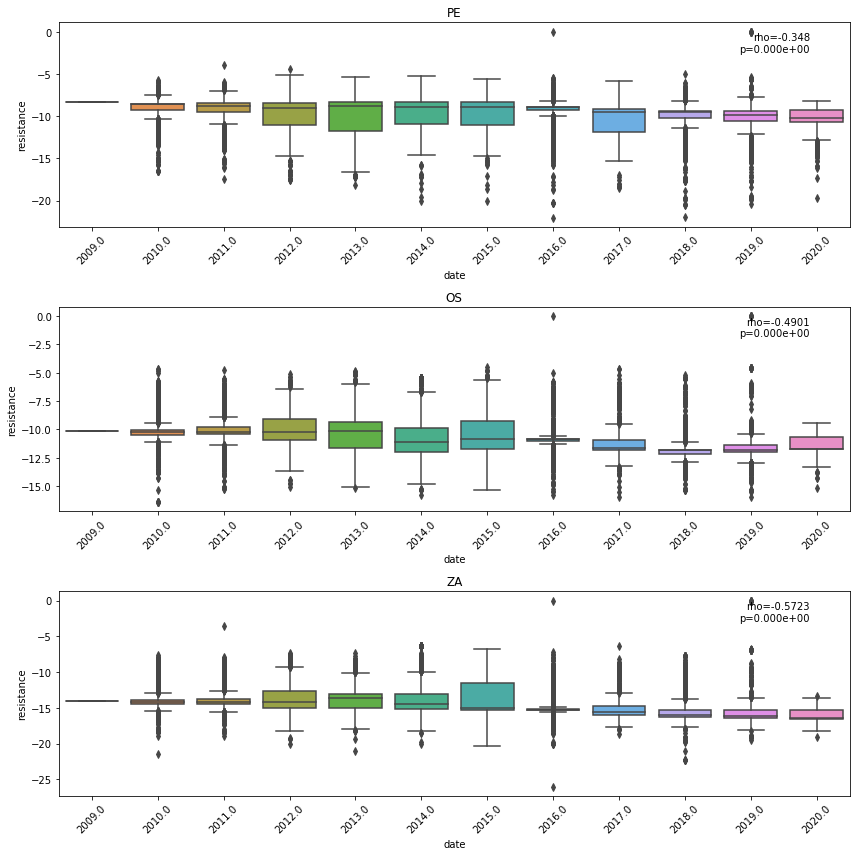

In [96]:
naturedata = naturedata.sort_values(by='date',ascending=True)
plt.figure(figsize=(12,12))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(3,1,ploti)
    #ax.scatter(naturedata['date'],naturedata['n.mut'],edgecolor='black',alpha=0.5)
    sns.boxplot(data=naturedata,x='date',y=drug+'_res',ax=ax)
    #plt.plot(naturedata['date'],naturedata['localnmut'],lw=4)
    plt.xticks(rotation=45)
    plt.ylabel('resistance')
    plt.title(drug)
    #plt.ylim([50,100])
    r,p = ss.spearmanr(naturedata['date'],naturedata[drug+'_res'])
    plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('time_res.png',dpi=600)

In [26]:
localnmut = []
window = 100
naturedata = naturedata.sort_values(by='date',ascending=True)
for i in range(window):
    localnmut.append(np.mean(naturedata['n.mut'][:i+1]))
for i in range(len(naturedata)-window):
    localnmut.append(np.mean(naturedata['n.mut'][i:i+window]))
naturedata['localnmut'] = localnmut

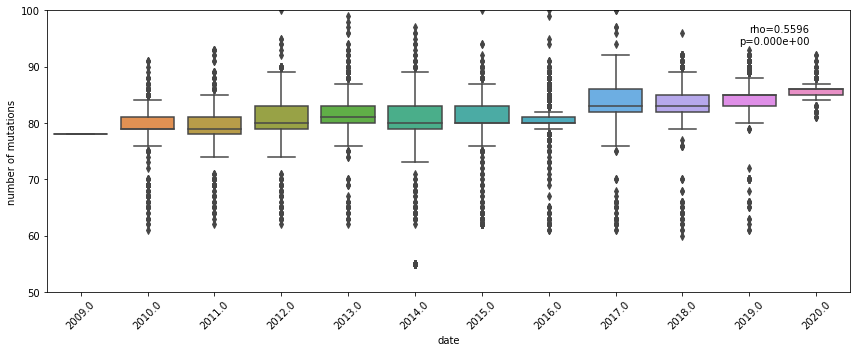

In [97]:
plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
#ax.scatter(naturedata['date'],naturedata['n.mut'],edgecolor='black',alpha=0.5)
sns.boxplot(data=naturedata,x='date',y='n.mut')
#plt.plot(naturedata['date'],naturedata['localnmut'],lw=4)
plt.xticks(rotation=45)
plt.ylabel('number of mutations')
plt.ylim([50,100])
r,p = ss.spearmanr(naturedata['date'],naturedata['n.mut'])
plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('time_mut_number.png',dpi=600)

In [28]:
localmean = []
window = 1000
for i in range(window):
    localmean.append(np.mean(naturedata['infered fitness'][:i+1]))
for i in range(len(naturedata)-window):
    localmean.append(np.mean(naturedata['infered fitness'][i:i+window]))
naturedata['localmean'] = localmean
naturedata = naturedata[-naturedata['infered fitness'].isnull()]

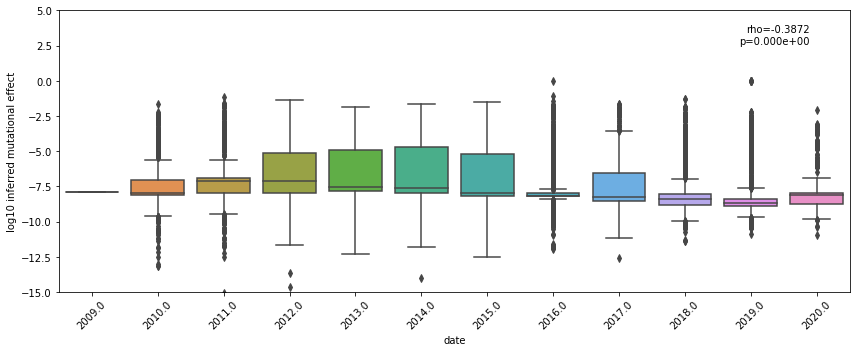

In [98]:
plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
#ax.scatter(naturedata['date'],naturedata['infered fitness'],edgecolor='black',alpha=0.01)
sns.boxplot(data=naturedata,x='date',y='infered fitness')
#plt.plot(naturedata['date'][window:],naturedata['localmean'][window:],lw=4,c='orange')
plt.xticks(rotation=45)
plt.ylabel('log10 inferred mutational effect')
plt.ylim([-15,5])
r,p = ss.spearmanr(naturedata['date'],naturedata['infered fitness'])
plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('time_fitness.png',dpi=600)

In [283]:
naturedata

,sequence,infered fitness,date,n.mut,country,PE_res,ZA_res,OS_res
0,MNPNQKIITIGSVSLIIATICFLMQVAILLTTFRQHDCNSSPNNQV...,-60.677882,2016.0,261,Iowa,-22.036729,-26.021165,-11.783947
1,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,-6.123439,2010.0,227,Indiana,-5.804343,-10.904217,-7.249606
2,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,-7.881529,2016.0,200,New York,-5.695883,-8.460976,-5.050320
3,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,-6.664156,2018.0,190,South Africa,-6.754654,-11.633169,-8.412156
4,MNPNQKIITIGSICMVTGIVSLMLQVGNMISIWVNHSIHTGNQHQA...,-6.733793,2013.0,162,Viet Nam,-7.459880,-11.535042,-7.416309
...,...,...,...,...,...,...,...,...
19123,MNPNQKIITIGSICMTIGIASLALQIGNIVSIWISHSIQIENKNQH...,-9.266466,2012.0,83,Mexico,-12.566997,-16.941885,-11.606745
19124,MNPNQKIITIGSICMTIGIASLALQIGNIVSIWISHSIQIENKNQH...,-9.266466,2012.0,83,Mexico,-12.566997,-16.941885,-11.606745
19125,MNPNQKIITIGSICMTIGIASLALQIGNIVSIWISHSIQIENKNQH...,-9.266466,2012.0,83,Mexico,-12.566997,-16.941885,-11.606745
19126,MNPNQKIITIGSICMAIGIASLTLQIGNIISIWISHSIQIENQNQL...,-8.710464,2011.0,80,Denmark,-11.497188,-17.352628,-12.843917


In [284]:
newdata = naturedata[naturedata['date']>2009]
newdata

,sequence,infered fitness,date,n.mut,country,PE_res,ZA_res,OS_res
0,MNPNQKIITIGSVSLIIATICFLMQVAILLTTFRQHDCNSSPNNQV...,-60.677882,2016.0,261,Iowa,-22.036729,-26.021165,-11.783947
1,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,-6.123439,2010.0,227,Indiana,-5.804343,-10.904217,-7.249606
2,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,-7.881529,2016.0,200,New York,-5.695883,-8.460976,-5.050320
3,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,-6.664156,2018.0,190,South Africa,-6.754654,-11.633169,-8.412156
4,MNPNQKIITIGSICMVTGIVSLMLQVGNMISIWVNHSIHTGNQHQA...,-6.733793,2013.0,162,Viet Nam,-7.459880,-11.535042,-7.416309
...,...,...,...,...,...,...,...,...
19123,MNPNQKIITIGSICMTIGIASLALQIGNIVSIWISHSIQIENKNQH...,-9.266466,2012.0,83,Mexico,-12.566997,-16.941885,-11.606745
19124,MNPNQKIITIGSICMTIGIASLALQIGNIVSIWISHSIQIENKNQH...,-9.266466,2012.0,83,Mexico,-12.566997,-16.941885,-11.606745
19125,MNPNQKIITIGSICMTIGIASLALQIGNIVSIWISHSIQIENKNQH...,-9.266466,2012.0,83,Mexico,-12.566997,-16.941885,-11.606745
19126,MNPNQKIITIGSICMAIGIASLTLQIGNIISIWISHSIQIENQNQL...,-8.710464,2011.0,80,Denmark,-11.497188,-17.352628,-12.843917


In [102]:
def find_mut(x):
    muts = []
    for i in range(len(refaa)):
        if refaa[i]!=x[i]: muts.append(str(refaa[i])+str(i+1)+str(x[i]))
    return '_'.join(muts)

def find_occurence(mut):
    tmpdata = newdata[newdata['muts'].str.contains(mut,regex=False)]
    return len(tmpdata)/len(newdata)

def find_muttype(mut):
    if mut[-1] == mut[0]:
        return 'silent'
    if mut[-1] == '*':
        return 'nonsense'
    return 'missense'

sdata['mut_type'] = sdata['mutation'].apply(lambda x:find_muttype(x))
newdata['muts'] = newdata['sequence'].apply(lambda x:find_mut(x))
sdata['occurence'] = sdata['mutation'].apply(lambda x:find_occurence(x))

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
aaposlist = range(7,408)
rdata = pd.DataFrame(data={'aapos':aaposlist})
rdata

,aapos
0,7
1,8
2,9
3,10
4,11
...,...
396,403
397,404
398,405
399,406


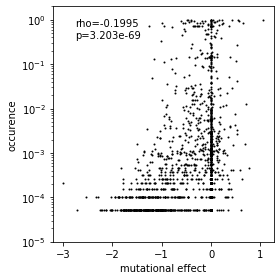

In [104]:
plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.scatter(sdata[sdata['mut_type']=='missense']['mutational effect'],sdata[sdata['mut_type']=='missense']['occurence'],edgecolor='black',s=1)
plt.xlabel('mutational effect')
plt.ylabel('occurence')
plt.yscale('log')
#plt.plot([1,1],[1e-6,1e0],linestyle='--',lw=2,color='grey')
plt.ylim([1e-5,2e0])
r,p = ss.spearmanr(sdata[sdata['mut_type']=='missense']['mutational effect'],sdata[sdata['mut_type']=='missense']['occurence'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('natural_occurence_fitness.png',dpi=600)

In [105]:
tsdata = sdata[sdata['mutational effect']!=0]
tsdata

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res,mut_type,occurence
15,I7M,7,M,-0.628267,-0.312234,-0.323477,-0.129810,missense,0.001046
22,I8K,8,K,-0.917841,-0.006139,-0.176421,-0.493197,missense,0.000000
27,I8T,8,T,-0.192717,0.546549,0.108282,0.142756,missense,0.001516
34,I8I,8,I,-0.018038,-0.385849,-0.208601,-1.136322,silent,0.000000
35,I8L,8,L,-1.042660,-0.340293,1.988857,-0.317151,missense,0.000471
...,...,...,...,...,...,...,...,...,...
8397,F406Y,406,Y,-1.124244,-0.236117,-0.471114,-0.175420,missense,0.000000
8398,F406V,406,V,-1.392957,-0.337555,-0.192421,-0.030224,missense,0.000000
8400,W407R,407,R,-1.570295,-0.087834,-0.128475,0.113099,missense,0.000052
8414,W407L,407,L,-1.005197,-0.054299,-0.010601,-0.294586,missense,0.000000


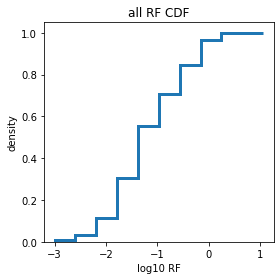

In [137]:
def fix_hist_step_vertical_line_at_end(ax):
    axpolygons = [poly for poly in ax.get_children() if isinstance(poly, matplotlib.patches.Polygon)]
    for poly in axpolygons:
        poly.set_xy(poly.get_xy()[:-1])

fig, ax = plt.subplots(figsize=(4,4))
plt.hist(tsdata[tsdata['mut_type']=='missense']['mutational effect'],cumulative=True,density=True,histtype='step',lw=3)
plt.xlabel('log10 RF')
plt.ylabel('density')
plt.title('all RF CDF')
fix_hist_step_vertical_line_at_end(ax)
plt.tight_layout()
plt.savefig('CDF_RF_all.png',dpi = 600)

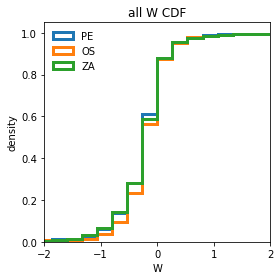

In [138]:
fig, ax = plt.subplots(figsize=(4,4))
for drug in druglist:
    plt.hist(tsdata[tsdata['mut_type']=='missense']['log10_'+drug+'_res'],cumulative=True,density=True,histtype='step',lw=3,label=drug,bins=30)
plt.xlabel('W')
plt.ylabel('density')
plt.title('all W CDF')
plt.legend(loc='upper left',frameon=False)
plt.xlim(-2,2)
fix_hist_step_vertical_line_at_end(ax)
plt.tight_layout()
plt.savefig('CDF_resistance_all.png',dpi = 600)

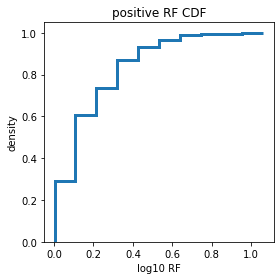

In [139]:
fig, ax = plt.subplots(figsize=(4,4))
tmpdata = tsdata[(tsdata['mut_type']=='missense')&(tsdata['mutational effect']>0)]
plt.hist(tmpdata['mutational effect'],cumulative=True,density=True,histtype='step',lw=3)
plt.xlabel('log10 RF')
plt.ylabel('density')
plt.title('positive RF CDF')
fix_hist_step_vertical_line_at_end(ax)
plt.tight_layout()
plt.savefig('CDF_RF_positive.png',dpi = 600)

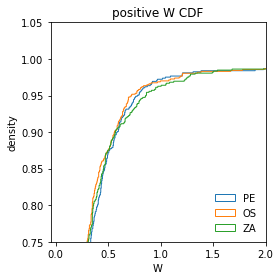

In [217]:
fig, ax = plt.subplots(figsize=(4,4))
for drug in druglist:
    tmpdata = tsdata[(tsdata['mut_type']=='missense')&(tsdata['log10_'+drug+'_res']>0)]
    plt.hist(tmpdata['log10_'+drug+'_res'],cumulative=True,density=True,histtype='step',lw=1,label=drug,bins=1000)
plt.xlabel('W')
plt.ylabel('density')
plt.title('positive W CDF')
plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.05,2)
plt.ylim(0.75,1.05)
fix_hist_step_vertical_line_at_end(ax)
plt.tight_layout()
plt.savefig('CDF_resistance_positive_zoom.png',dpi = 600)

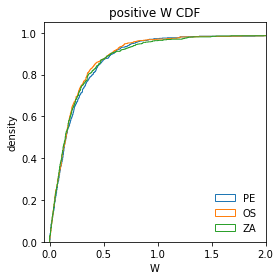

In [218]:
fig, ax = plt.subplots(figsize=(4,4))
for drug in druglist:
    tmpdata = tsdata[(tsdata['mut_type']=='missense')&(tsdata['log10_'+drug+'_res']>0)]
    plt.hist(tmpdata['log10_'+drug+'_res'],cumulative=True,density=True,histtype='step',lw=1,label=drug,bins=1000)
plt.xlabel('W')
plt.ylabel('density')
plt.title('positive W CDF')
plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.05,2)
fix_hist_step_vertical_line_at_end(ax)
plt.tight_layout()
plt.savefig('CDF_resistance_positive.png',dpi = 600)

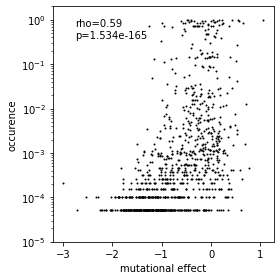

In [113]:
plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.scatter(tsdata[tsdata['mut_type']=='missense']['mutational effect'],tsdata[tsdata['mut_type']=='missense']['occurence'],edgecolor='black',s=1)
plt.xlabel('mutational effect')
plt.ylabel('occurence')
plt.yscale('log')
#plt.plot([1,1],[1e-6,1e0],linestyle='--',lw=2,color='grey')
plt.ylim([1e-5,2e0])
r,p = ss.spearmanr(tsdata[tsdata['mut_type']=='missense']['mutational effect'],tsdata[tsdata['mut_type']=='missense']['occurence'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('natural_occurence_fitness_0filtered.png',dpi=600)

In [106]:
def calc_entropy(aapos):
    freqlist = list(sdata[sdata['aapos']==aapos]['occurence'])
    wtfreq = 1-sum(freqlist)
    return ss.entropy(freqlist+[wtfreq])

def fit_per_pos(aapos):
    return np.mean(tsdata[tsdata['aapos']==aapos]['mutational effect'])

rdata['entropy'] = rdata['aapos'].apply(lambda x:calc_entropy(x))
rdata['meanfit'] = rdata['aapos'].apply(lambda x:fit_per_pos(x))
rdata

,aapos,entropy,meanfit
0,7,0.018399,-0.628267
1,8,0.209487,-0.510883
2,9,0.170716,-0.172017
3,10,0.014040,-0.828071
4,11,0.056015,-0.341555
...,...,...,...
396,403,0.033808,-0.859353
397,404,0.002271,-0.547280
398,405,0.000568,-1.137416
399,406,0.001631,-1.031661


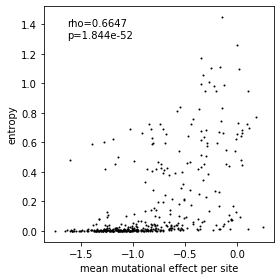

In [107]:
plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.scatter(rdata['meanfit'],rdata['entropy'],edgecolor='black',s=1)
plt.xlabel('mean mutational effect per site')
plt.ylabel('entropy')
r,p = ss.spearmanr(rdata['meanfit'],rdata['entropy'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('entropy_fitness.png',dpi=600)

In [108]:
def res_per_pos(aapos,drug):
    return np.mean(tsdata[tsdata['aapos']==aapos]['log10_'+drug+'_res'])

for drug in druglist:
    rdata['meanres'+drug] = rdata['aapos'].apply(lambda x:res_per_pos(x,drug))

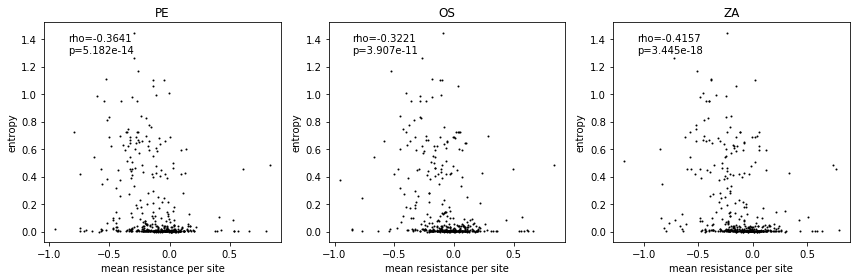

In [109]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    plt.scatter(rdata['meanres'+drug],rdata['entropy'],edgecolor='black',s=1)
    plt.xlabel('mean resistance per site')
    plt.ylabel('entropy')
    plt.title(drug)
    r,p = ss.spearmanr(rdata['meanres'+drug],rdata['entropy'])
    plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('entropy_resistance.png',dpi=600)

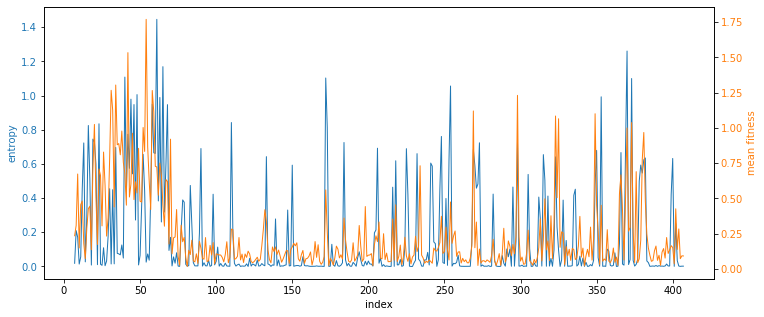

In [110]:
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(rdata['aapos'],rdata['entropy'],lw=1,color='tab:blue')
ax2 = ax.twinx() 
ax2.plot(rdata['aapos'],10**rdata['meanfit'],lw=1,color='tab:orange')
ax.set_xlabel('index')
ax.set_ylabel('entropy',color='tab:blue')
ax2.set_ylabel('mean fitness',color='tab:orange')
ax.tick_params(axis='y',labelcolor='tab:blue')
ax2.tick_params(axis='y',labelcolor='tab:orange')

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


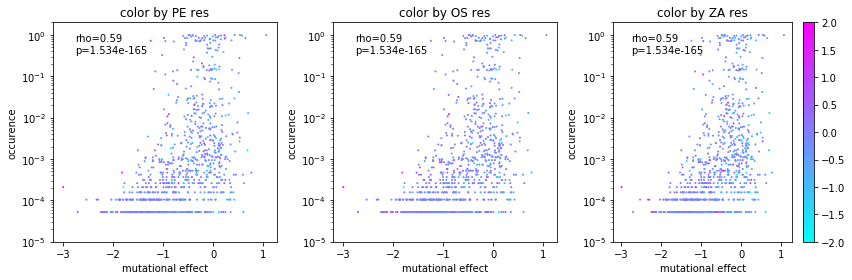

In [111]:
#color by res
cmap = matplotlib.cm.get_cmap('cool')

def res2col(x):
    color=(x-mincol)/(maxcol-mincol)
    return cmap(color)

plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    mincol = min(tsdata['log10_'+drug+'_res'])/2
    maxcol = max(tsdata['log10_'+drug+'_res'])/2
    tsdata[drug+'_color']=tsdata['log10_'+drug+'_res'].apply(lambda x:res2col(x))
    plt.scatter(tsdata[tsdata['mut_type']=='missense']['mutational effect'],tsdata[tsdata['mut_type']=='missense']['occurence'],color=tsdata[tsdata['mut_type']=='missense'][drug+'_color'],s=1)
    plt.xlabel('mutational effect')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.ylim([1e-5,2e0])
    r,p = ss.spearmanr(tsdata[tsdata['mut_type']=='missense']['mutational effect'],tsdata[tsdata['mut_type']=='missense']['occurence'])
    plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
    plt.title('color by '+drug+' res')
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=mincol, vmax=maxcol), cmap=cmap))
plt.tight_layout()
plt.savefig('natural_occurence_fitness_res.png',dpi=600)

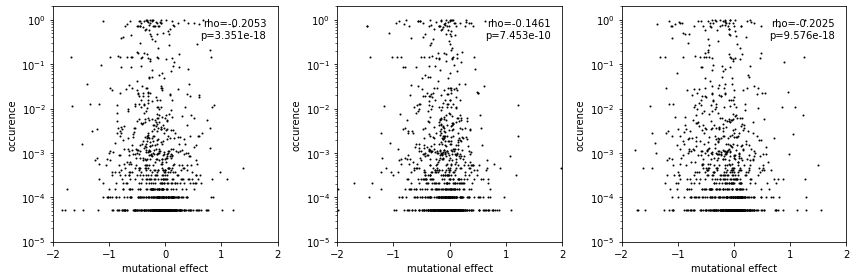

In [112]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    plt.scatter(tsdata[tsdata['mut_type']=='missense']['log10_'+drug+'_res'],tsdata[tsdata['mut_type']=='missense']['occurence'],edgecolor='black',s=1)
    plt.xlabel('mutational effect')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.xlim([-2,2])
    #plt.plot([1,1],[1e-6,1e0],linestyle='--',lw=2,color='grey')
    plt.ylim([1e-5,2e0])
    r,p = ss.spearmanr(tsdata[tsdata['mut_type']=='missense']['log10_'+drug+'_res'],tsdata[tsdata['mut_type']=='missense']['occurence'])
    plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('natural_occurence_resistance.png',dpi=600)

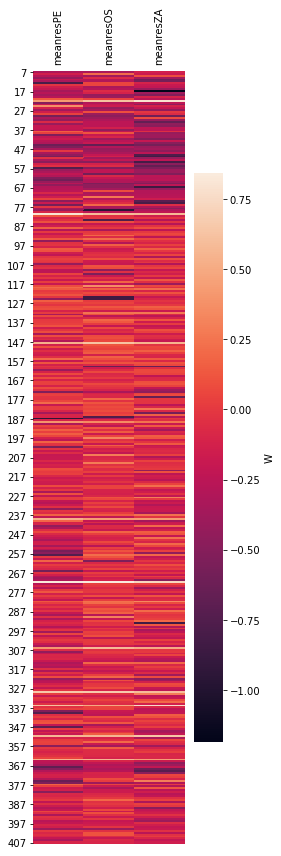

In [178]:
fig, ax = plt.subplots(figsize=(4,12))
sns.heatmap(rdata[['meanresPE','meanresOS','meanresZA']],ax=ax,yticklabels=np.arange(7,408,10), cbar_kws={'label': 'W'})
ax.set_yticks(np.arange(0,401,10)+0.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, labeltop=True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('resistance_heatmap.png',dpi=600)

In [188]:
respos = {}
for drug in druglist:
    infile = open('YS_input/'+drug+'Pos')
    respos[drug] = []
    for line in infile:
        respos[drug].append(float(line.rstrip()))
    infile.close()

In [194]:
for drug in druglist:
    rdata[drug+'Flag'] = rdata['aapos'].apply(lambda x:1 if x in respos[drug] else 0)

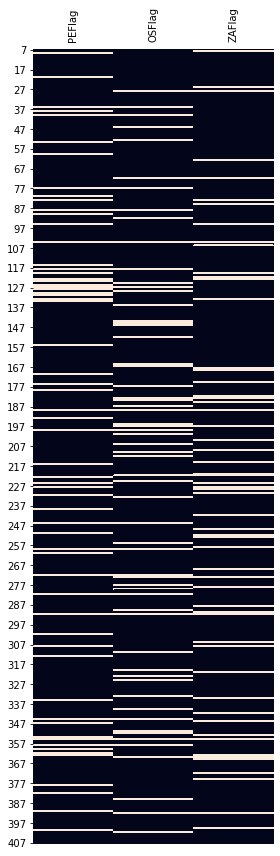

In [208]:
fig, ax = plt.subplots(figsize=(4,12))
sns.heatmap(rdata[['PEFlag','OSFlag','ZAFlag']],ax=ax,yticklabels=np.arange(7,408,10),cbar=False)
ax.set_yticks(np.arange(0,401,10)+0.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, labeltop=True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('resistance_heatmap_binary.png',dpi=600)

bad thing is WSN is very different from circulating strains.
good thing is mut frequency correlate with fitness well.

In [221]:
naturedata

,sequence,infered fitness,date,n.mut,PE_res,ZA_res,OS_res
18249,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,-7.902602,2009.0,78,-8.278421,-14.089360,-10.107376
19127,MNPNQKIITIGSICMAIGIVSLTLQIGNIISIWISHSIQLENKNQP...,-6.655608,2010.0,78,-10.298679,-15.805066,-10.945054
17939,MNPNQKIIIIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,-8.876999,2010.0,80,-7.779927,-14.140212,-10.133393
17938,MNPNQKIIIIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,-8.876999,2010.0,80,-7.779927,-14.140212,-10.133393
17937,MNPNQKIIIIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,-8.876999,2010.0,81,-7.779927,-14.140212,-10.133393
...,...,...,...,...,...,...,...
1552,MNTNQRIITIGTVCMIVGIISLLLQIGNIVSLWISHSIQIEWENHT...,-3.191152,2020.0,86,-14.101996,-17.227450,-13.344909
7030,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,-8.801072,2020.0,85,-10.720025,-15.420990,-10.698031
1550,MNTNQRIITIGTVCMIVGIISLLLQIGNIVSLWISHSIQIEWGNHT...,-3.191152,2020.0,86,-14.101996,-17.227450,-13.344909
1548,MNTNQRIITIGTVCMIVGIISLLLQIGNIVSLWISHSIQIEWENHT...,-3.277383,2020.0,85,-13.802716,-17.523629,-13.319968


## Per year occurence

In [222]:
def find_occurence(mut):
    tmpdata = newdata[newdata['date']==year]
    tmpdata1 = tmpdata[tmpdata['muts'].str.contains(mut,regex=False)]
    return len(tmpdata1)/len(tmpdata)

for year in range(2010,2021):
    tsdata['occurence_'+str(year)] = tsdata['mutation'].apply(lambda x:find_occurence(x))

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [229]:
resmut = {}
for drug in druglist:
    resmut[drug] = []
    infile = open('YS_input/'+drug+'_DrugResMut')
    for line in infile:
        resmut[drug].append(line.rstrip())
    infile.close()

In [231]:
for drug in druglist:
    tsdata[drug+'_resFlag'] = tsdata['mutation'].apply(lambda x:1 if x in resmut[drug] else 0)
    print('found drug resistance for '+drug+': '+str(sum(tsdata[drug+'_resFlag'])))

found drug resistance for PE: 86
found drug resistance for OS: 99
found drug resistance for ZA: 82


/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
def judge_change(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    if min(freqlist) < 0.05 and max(freqlist) > 0.5:
        return True
    return False

tsdata['changed_mut'] = tsdata.apply(lambda x:judge_change(x),axis=1)
cdata = tsdata[tsdata['changed_mut']]

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


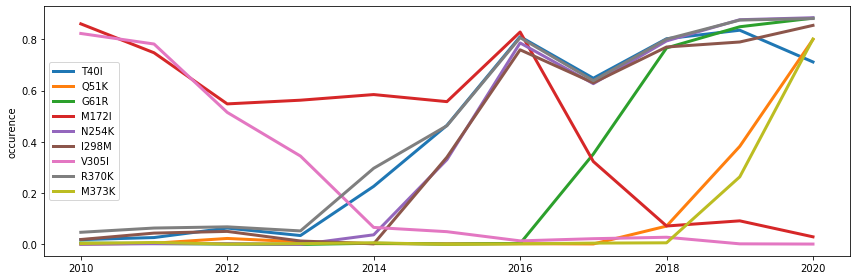

In [89]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    datelist = range(2010,2021)
    plt.plot(datelist,freqlist,label=x['mutation'],lw=3)
    
plt.figure(figsize=(12,4))
cdata.apply(lambda x:draw_line(x),axis=1)
plt.legend()
plt.ylabel('occurence')
plt.tight_layout()

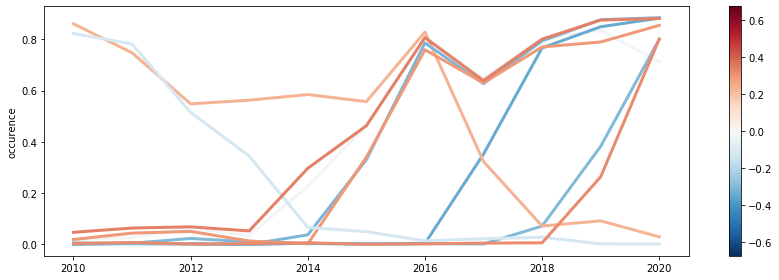

In [96]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    datelist = range(2010,2021)
    color=(x['mutational effect']-mincol)/(maxcol-mincol)
    plt.plot(datelist,freqlist,label=x['mutation'],lw=3,c=cmap(color))

cmap = matplotlib.cm.get_cmap('RdBu_r')
mincol = min(sdata['mutational effect'])
maxcol = max(sdata['mutational effect'])/2
mincol = -maxcol
plt.figure(figsize=(12,4))
cdata.apply(lambda x:draw_line(x),axis=1)
#plt.legend()
plt.ylabel('occurence')
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=mincol, vmax=maxcol), cmap=cmap))
plt.tight_layout()

In [86]:
sdata

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res,mut_type,occurence,occurence_2010,...,occurence_2012,occurence_2013,occurence_2014,occurence_2015,occurence_2016,occurence_2017,occurence_2018,occurence_2019,occurence_2020,changed_mut
0,I7R,7,R,0.000000,0.000000,0.000000,0.000000,missense,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
1,I7K,7,K,0.000000,0.000000,0.000000,0.000000,missense,0.000105,0.000522,...,0.0,0.000644,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
2,I7D,7,D,0.000000,0.000000,0.000000,0.000000,missense,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
3,I7E,7,E,0.000000,0.000000,0.000000,0.000000,missense,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
4,I7H,7,H,0.000000,0.000000,0.000000,0.000000,missense,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8416,W407F,407,F,0.000000,0.000000,0.000000,0.000000,missense,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
8417,W407W,407,W,0.000000,0.000000,0.000000,0.000000,silent,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
8418,W407Y,407,Y,0.000000,0.000000,0.000000,0.000000,missense,0.000052,0.000000,...,0.0,0.000000,0.0,0.0,0.000413,0.0,0.0,0.0,0.0,False
8419,W407V,407,V,0.000000,0.000000,0.000000,0.000000,missense,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False


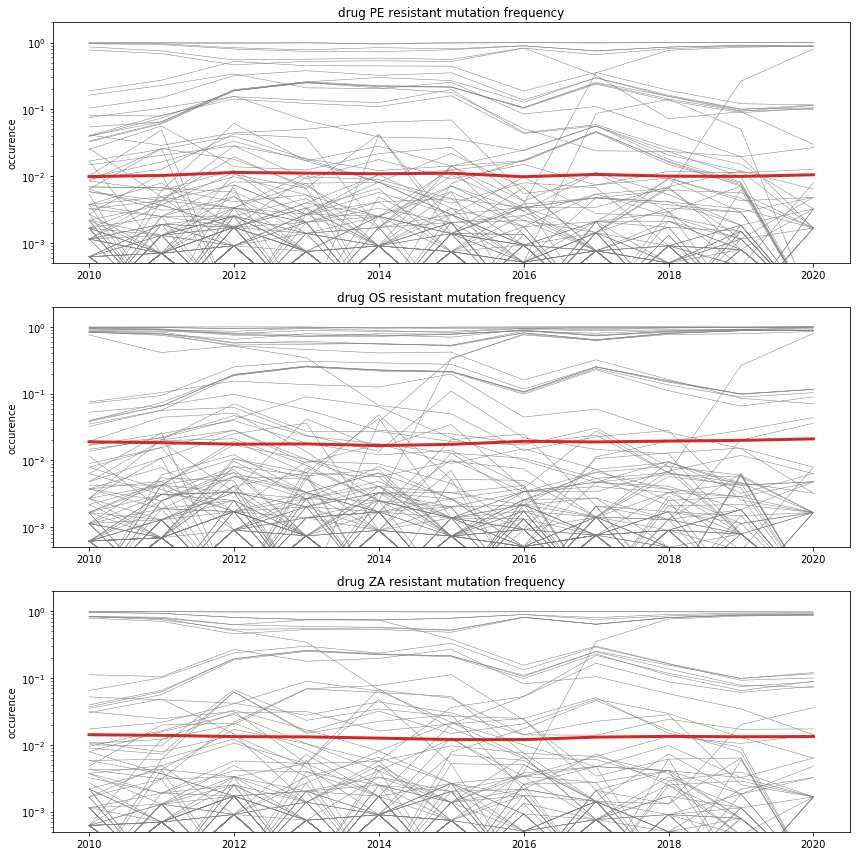

In [119]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)]+1e-4)
    datelist = range(2010,2021)
    plt.plot(datelist,freqlist,lw=0.5,color='grey')
    return freqlist

ploti = 0    
plt.figure(figsize=(12,12))
for drug in druglist:
    ploti += 1
    plt.subplot(3,1,ploti)
    resdata = tsdata[tsdata['log10_'+drug+'_res']>0]
    freqlists = resdata.apply(lambda x:draw_line(x),axis=1)
    averagefreq = {}
    for year in range(2010,2021):
        averagefreq[year] = []
    for freqlist in freqlists:
        for i,year in enumerate(range(2010,2021)):
            averagefreq[year].append(freqlist[i])
    for year in averagefreq:
        averagefreq[year] = np.mean(averagefreq[year])
    plt.plot(list(averagefreq.keys()),list(averagefreq.values()),lw=3,color='tab:red')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.ylim([5e-4,2e0])
    plt.title('drug '+drug+' resistant mutation frequency')
plt.tight_layout()

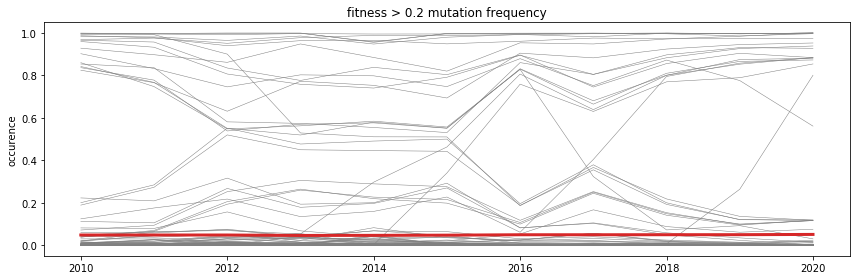

In [124]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)]+1e-4)
    datelist = range(2010,2021)
    plt.plot(datelist,freqlist,lw=0.5,color='grey')
    return freqlist
   
plt.figure(figsize=(12,4))
resdata = tsdata[tsdata['mutational effect']>0.2]
freqlists = resdata.apply(lambda x:draw_line(x),axis=1)
averagefreq = {}
for year in range(2010,2021):
    averagefreq[year] = []
for freqlist in freqlists:
    for i,year in enumerate(range(2010,2021)):
        averagefreq[year].append(freqlist[i])
for year in averagefreq:
    averagefreq[year] = np.mean(averagefreq[year])
plt.plot(list(averagefreq.keys()),list(averagefreq.values()),lw=3,color='tab:red')
plt.ylabel('occurence')
#plt.yscale('log')
#plt.ylim([5e-4,2e0])
plt.title('fitness > 0.2 mutation frequency')
plt.tight_layout()

In [125]:
averagefreq

{2010: 0.048125209955858166,
 2011: 0.04807001480361587,
 2012: 0.0480631441849031,
 2013: 0.0460207511906915,
 2014: 0.04647862336652948,
 2015: 0.04735849149728542,
 2016: 0.04929472984290413,
 2017: 0.049300934434852554,
 2018: 0.04946768711803645,
 2019: 0.04962371082907639,
 2020: 0.05087086656034024}

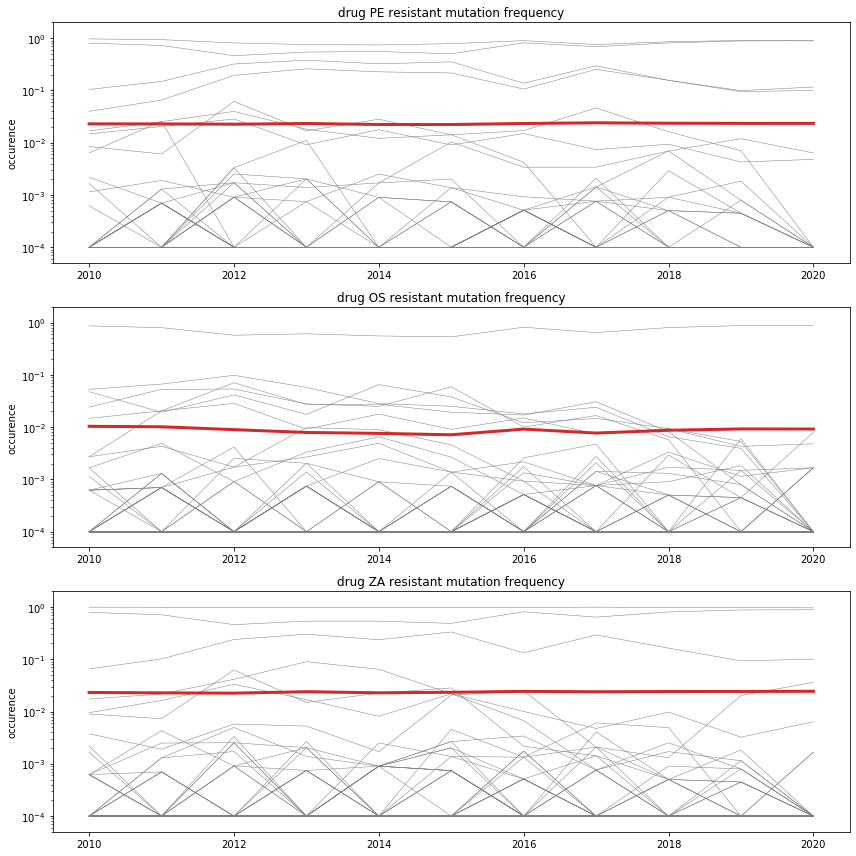

In [238]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)]+1e-4)
    datelist = range(2010,2021)
    plt.plot(datelist,freqlist,lw=0.5,color='grey')
    return freqlist

ploti = 0    
plt.figure(figsize=(12,12))
for drug in druglist:
    ploti += 1
    plt.subplot(3,1,ploti)
    resdata = tsdata[tsdata[drug+'_resFlag']>0]
    freqlists = resdata.apply(lambda x:draw_line(x),axis=1)
    averagefreq = {}
    for year in range(2010,2021):
        averagefreq[year] = []
    for freqlist in freqlists:
        for i,year in enumerate(range(2010,2021)):
            averagefreq[year].append(freqlist[i])
    for year in averagefreq:
        averagefreq[year] = np.mean(averagefreq[year])
    plt.plot(list(averagefreq.keys()),list(averagefreq.values()),lw=3,color='tab:red')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.ylim([5e-5,2e0])
    plt.title('drug '+drug+' resistant mutation frequency')
plt.tight_layout()
plt.savefig('all_drug_resistance_mutation_dynamics.png',dpi=600)

In [239]:
#only look at mutations with at least one year above >1%
def judge_major(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    if max(freqlist) > 0.01:
        return True
    return False

tsdata['majorFlag'] = tsdata.apply(lambda x:judge_major(x),axis=1)

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


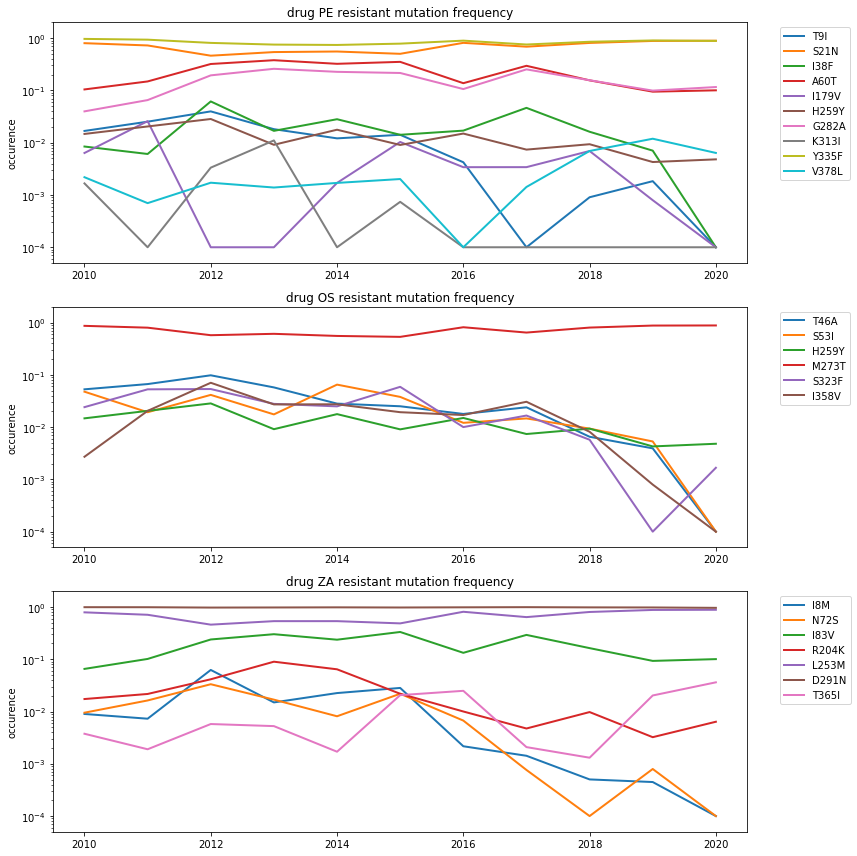

In [245]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)]+1e-4)
    datelist = range(2010,2021)
    plt.plot(datelist,freqlist,lw=2,label=x['mutation'])
    return freqlist

ploti = 0    
plt.figure(figsize=(12,12))
for drug in druglist:
    ploti += 1
    plt.subplot(3,1,ploti)
    resdata = tsdata[(tsdata[drug+'_resFlag']>0)&(tsdata['majorFlag'])]
    freqlists = resdata.apply(lambda x:draw_line(x),axis=1)
    averagefreq = {}
    for year in range(2010,2021):
        averagefreq[year] = []
    for freqlist in freqlists:
        for i,year in enumerate(range(2010,2021)):
            averagefreq[year].append(freqlist[i])
    for year in averagefreq:
        averagefreq[year] = np.mean(averagefreq[year])
    plt.legend(bbox_to_anchor=(1.04,1))
    #plt.plot(list(averagefreq.keys()),list(averagefreq.values()),lw=3,color='tab:red')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.ylim([5e-5,2e0])
    plt.title('drug '+drug+' resistant mutation frequency')
plt.tight_layout()
plt.savefig('High_frequency_drug_resistance_mutation_dynamics.png',dpi=600)

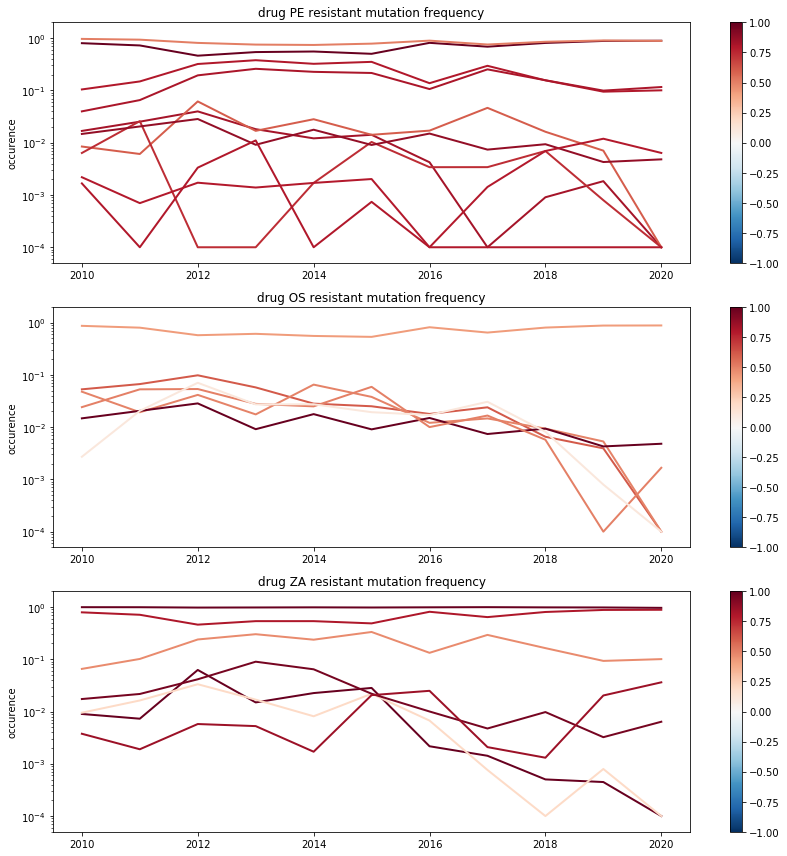

In [251]:
def draw_line(x,drug):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)]+1e-4)
    datelist = range(2010,2021)
    color=(x['log10_'+drug+'_res']-mincol)/(maxcol-mincol)
    plt.plot(datelist,freqlist,lw=2,label=x['mutation'],c=cmap(color))
    return freqlist


cmap = matplotlib.cm.get_cmap('RdBu_r')

ploti = 0    
plt.figure(figsize=(12,12))
for drug in druglist:
    ploti += 1
    plt.subplot(3,1,ploti)
    mincol = -1
    maxcol = 1
    resdata = tsdata[(tsdata[drug+'_resFlag']>0)&(tsdata['majorFlag'])]
    freqlists = resdata.apply(lambda x:draw_line(x,drug),axis=1)
    averagefreq = {}
    for year in range(2010,2021):
        averagefreq[year] = []
    for freqlist in freqlists:
        for i,year in enumerate(range(2010,2021)):
            averagefreq[year].append(freqlist[i])
    for year in averagefreq:
        averagefreq[year] = np.mean(averagefreq[year])
    plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=mincol, vmax=maxcol), cmap=cmap))
    #plt.plot(list(averagefreq.keys()),list(averagefreq.values()),lw=3,color='tab:red')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.ylim([5e-5,2e0])
    plt.title('drug '+drug+' resistant mutation frequency')
plt.tight_layout()
plt.savefig('High_frequency_drug_resistance_mutation_dynamics_colorbyResistance.png',dpi=600)

In [248]:
tsdata

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res,mut_type,occurence,PE_color,...,occurence_2015,occurence_2016,occurence_2017,occurence_2018,occurence_2019,occurence_2020,PE_resFlag,OS_resFlag,ZA_resFlag,majorFlag
15,I7M,7,M,-0.628267,-0.312234,-0.323477,-0.129810,missense,0.001046,"(0.4235294117647059, 0.5764705882352941, 1.0, ...",...,0.001918,0.000000,0.000000,0.000805,0.002085,0.004702,0,0,0,False
22,I8K,8,K,-0.917841,-0.006139,-0.176421,-0.493197,missense,0.000000,"(0.4980392156862745, 0.5019607843137255, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False
27,I8T,8,T,-0.192717,0.546549,0.108282,0.142756,missense,0.001516,"(0.6352941176470588, 0.3647058823529412, 1.0, ...",...,0.001918,0.002064,0.001323,0.000402,0.000000,0.000000,0,0,0,False
34,I8I,8,I,-0.018038,-0.385849,-0.208601,-1.136322,silent,0.000000,"(0.403921568627451, 0.596078431372549, 1.0, 1.0)",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False
35,I8L,8,L,-1.042660,-0.340293,1.988857,-0.317151,missense,0.000471,"(0.4156862745098039, 0.5843137254901961, 1.0, ...",...,0.003197,0.000000,0.001323,0.000000,0.000000,0.000000,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8397,F406Y,406,Y,-1.124244,-0.236117,-0.471114,-0.175420,missense,0.000000,"(0.4392156862745098, 0.5607843137254902, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False
8398,F406V,406,V,-1.392957,-0.337555,-0.192421,-0.030224,missense,0.000000,"(0.4156862745098039, 0.5843137254901961, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False
8400,W407R,407,R,-1.570295,-0.087834,-0.128475,0.113099,missense,0.000052,"(0.4784313725490196, 0.5215686274509804, 1.0, ...",...,0.000639,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False
8414,W407L,407,L,-1.005197,-0.054299,-0.010601,-0.294586,missense,0.000000,"(0.48627450980392156, 0.5137254901960784, 1.0,...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False


## Geographic analysis

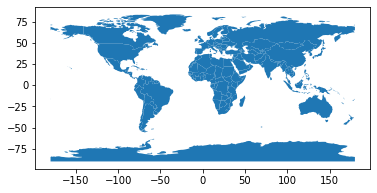

In [255]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

In [262]:
located = 0
countrylist = []
for seqname in seqdict:
    try:
        country = seqname.rsplit('|')[4].rsplit('/')[-3]
        located += 1
        countrylist.append(country)
    except:
        continue
print(located)

19136


In [263]:
countryfreq = dict(Counter(countrylist).most_common())
address = []
for place in list(countryfreq.keys()):
    try:
        address.append(gpd.tools.geocode(place,provider='nominatim', user_agent="tianhao@ucla.edu:NAdrug"))
    except:
        address.append('NA')

In [265]:
def find_country(x):
    for index,row in world.iterrows():
        if x.within(row['geometry']):
            return str(row['name'])
    return 'NA'

countryref = []
for place in address:
    if isinstance(place, str):
        countryref.append('NA')
    else:
        countryref.append(find_country(place['geometry'].iloc[0]))
        
newcountrydict = {}
for i,country in enumerate(countryfreq.keys()):
    newcountry = countryref[i]
    if newcountry not in newcountrydict: newcountrydict[newcountry] = 0
    newcountrydict[newcountry] += countryfreq[country]

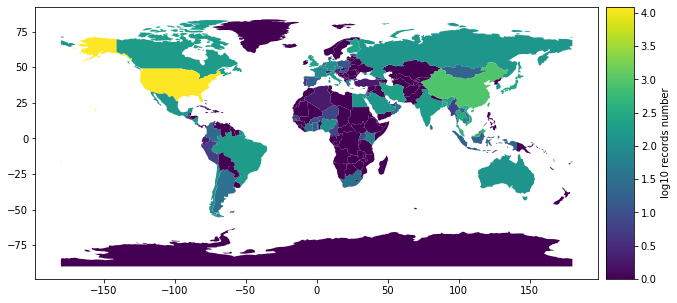

In [272]:
world['records_c'] = world['name'].apply(lambda x:np.log10(newcountrydict[x]) if x in newcountrydict else 0)
fig, ax = plt.subplots(1, 1,figsize=(12,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='records_c',ax=ax, legend=True, cax=cax,legend_kwds={'label': "log10 records number"})
plt.savefig('record_number_by_country.png',dpi=600)

In [279]:
georef = {}
for i,place in enumerate(countryref):
    georef[list(countryfreq.keys())[i]] = place

## ddG

In [289]:
ddgdata = pd.read_csv('YS_input/20210625_ddg.txt',sep='\t',names=['mutation','aapos','ddG'],header=1)
ddgdata

,mutation,aapos,ddG
0,V83C,83,1.414382
1,V83D,83,6.858518
2,V83E,83,7.840274
3,V83F,83,4.841530
4,V83G,83,1.907572
...,...,...,...
8079,I467V,467,0.173061
8080,I467W,467,3.706291
8081,I467Y,467,3.429690
8082,I467X,467,0.644561


In [291]:
ddgdata['aaFlag'] = ddgdata['mutation'].apply(lambda x:False if x[-1]=='X' or x[-1]=='Z' else True)
ddgdata = ddgdata[ddgdata['aaFlag']]
ddgdata

,mutation,aapos,ddG,aaFlag
0,V83C,83,1.414382,True
1,V83D,83,6.858518,True
2,V83E,83,7.840274,True
3,V83F,83,4.841530,True
4,V83G,83,1.907572,True
...,...,...,...,...
8077,I467S,467,4.483757,True
8078,I467T,467,1.786302,True
8079,I467V,467,0.173061,True
8080,I467W,467,3.706291,True


In [303]:
def find_ddg(x):
    mut = x[0]+str(int(x[1:-1])+16)+x[-1]
    tmpdata = ddgdata[ddgdata['mutation']==mut]
    if len(tmpdata) == 0: return 0
    return tmpdata['ddG'].iloc[0]

tsdata['ddg'] = tsdata['mutation'].apply(lambda x:find_ddg(x))
tsdata

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res,mut_type,occurence,PE_color,...,occurence_2016,occurence_2017,occurence_2018,occurence_2019,occurence_2020,PE_resFlag,OS_resFlag,ZA_resFlag,majorFlag,ddg
15,I7M,7,M,-0.628267,-0.312234,-0.323477,-0.129810,missense,0.001046,"(0.4235294117647059, 0.5764705882352941, 1.0, ...",...,0.000000,0.000000,0.000805,0.002085,0.004702,0,0,0,False,0.000000
22,I8K,8,K,-0.917841,-0.006139,-0.176421,-0.493197,missense,0.000000,"(0.4980392156862745, 0.5019607843137255, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False,0.000000
27,I8T,8,T,-0.192717,0.546549,0.108282,0.142756,missense,0.001516,"(0.6352941176470588, 0.3647058823529412, 1.0, ...",...,0.002064,0.001323,0.000402,0.000000,0.000000,0,0,0,False,0.000000
34,I8I,8,I,-0.018038,-0.385849,-0.208601,-1.136322,silent,0.000000,"(0.403921568627451, 0.596078431372549, 1.0, 1.0)",...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False,0.000000
35,I8L,8,L,-1.042660,-0.340293,1.988857,-0.317151,missense,0.000471,"(0.4156862745098039, 0.5843137254901961, 1.0, ...",...,0.000000,0.001323,0.000000,0.000000,0.000000,0,0,0,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8397,F406Y,406,Y,-1.124244,-0.236117,-0.471114,-0.175420,missense,0.000000,"(0.4392156862745098, 0.5607843137254902, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False,2.300155
8398,F406V,406,V,-1.392957,-0.337555,-0.192421,-0.030224,missense,0.000000,"(0.4156862745098039, 0.5843137254901961, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False,5.171290
8400,W407R,407,R,-1.570295,-0.087834,-0.128475,0.113099,missense,0.000052,"(0.4784313725490196, 0.5215686274509804, 1.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False,11.168803
8414,W407L,407,L,-1.005197,-0.054299,-0.010601,-0.294586,missense,0.000000,"(0.48627450980392156, 0.5137254901960784, 1.0,...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,False,1.715760


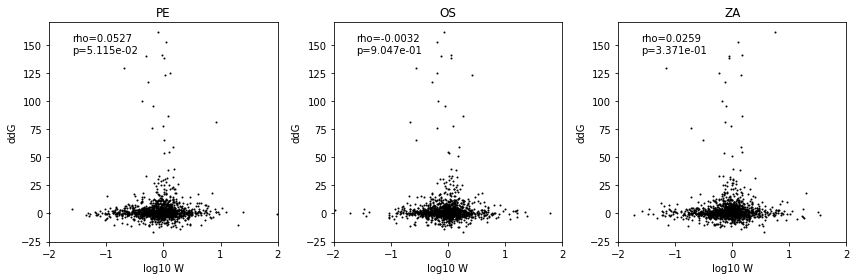

In [315]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    tmpdata = tsdata[(tsdata['ddg']!=0)&(tsdata['mut_type']=='missense')]
    plt.scatter(tmpdata['log10_'+drug+'_res'],tmpdata['ddg'],edgecolor='black',s=1)
    plt.xlabel('log10 W')
    plt.ylabel('ddG')
    plt.title(drug)
    #plt.ylim(-20,50)
    plt.xlim(-2,2)
    r,p = ss.spearmanr(tmpdata['log10_'+drug+'_res'],tmpdata['ddg'])
    plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('ddG_W.png',dpi=600)

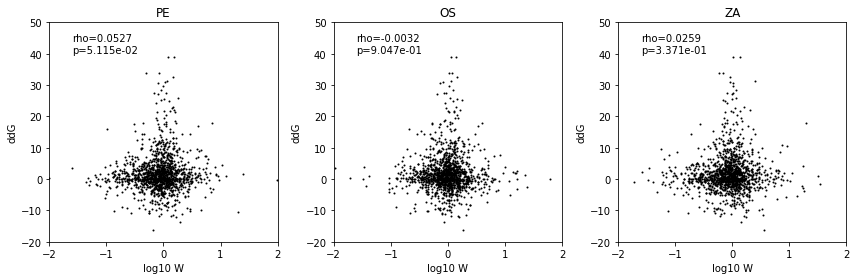

In [313]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    tmpdata = tsdata[(tsdata['ddg']!=0)&(tsdata['mut_type']=='missense')]
    plt.scatter(tmpdata['log10_'+drug+'_res'],tmpdata['ddg'],edgecolor='black',s=1)
    plt.xlabel('log10 W')
    plt.ylabel('ddG')
    plt.title(drug)
    plt.ylim(-20,50)
    plt.xlim(-2,2)
    r,p = ss.spearmanr(tmpdata['log10_'+drug+'_res'],tmpdata['ddg'])
    plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('ddG_W_zoom.png',dpi=600)

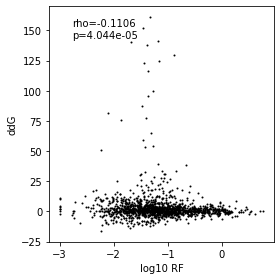

In [319]:
fig,ax = plt.subplots(figsize=(4,4))
tmpdata = tsdata[(tsdata['ddg']!=0)&(tsdata['mut_type']=='missense')]
plt.scatter(tmpdata['mutational effect'],tmpdata['ddg'],edgecolor='black',s=1)
plt.xlabel('log10 RF')
plt.ylabel('ddG')
#plt.ylim(-20,50)
r,p = ss.spearmanr(tmpdata['mutational effect'],tmpdata['ddg'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('ddG_RF.png',dpi=600)

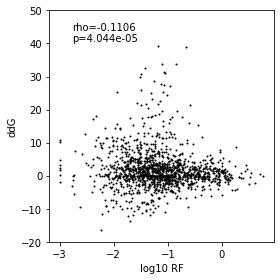

In [336]:
fig,ax = plt.subplots(figsize=(4,4))
tmpdata = tsdata[(tsdata['ddg']!=0)&(tsdata['mut_type']=='missense')]
plt.scatter(tmpdata['mutational effect'],tmpdata['ddg'],edgecolor='black',s=1)
plt.xlabel('log10 RF')
plt.ylabel('ddG')
plt.ylim(-20,50)
r,p = ss.spearmanr(tmpdata['mutational effect'],tmpdata['ddg'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('ddG_RF_zoom.png',dpi=600)

In [322]:
ddgdata

,mutation,aapos,ddG,aaFlag
0,V83C,83,1.414382,True
1,V83D,83,6.858518,True
2,V83E,83,7.840274,True
3,V83F,83,4.841530,True
4,V83G,83,1.907572,True
...,...,...,...,...
8077,I467S,467,4.483757,True
8078,I467T,467,1.786302,True
8079,I467V,467,0.173061,True
8080,I467W,467,3.706291,True


In [329]:
def calc_ddg(x):
    tmpdata = ddgdata[ddgdata['aapos']==x+16]
    if len(tmpdata) == 0: return 0
    return np.mean(tmpdata['ddG'])

rdata['mean_ddg'] = rdata['aapos'].apply(lambda x:calc_ddg(x))
rdata

,aapos,entropy,meanfit,meanresPE,meanresOS,meanresZA,PEFlag,OSFlag,ZAFlag,gmean_ddg,mean_ddg
0,7,0.018399,-0.628267,-0.312234,-0.323477,-0.129810,0,0,0,NaN,0.000000
1,8,0.209487,-0.510883,-0.137071,0.215530,-0.166426,0,0,1,NaN,0.000000
2,9,0.170716,-0.172017,-0.273039,-0.363878,0.097197,1,0,0,NaN,0.000000
3,10,0.014040,-0.828071,-0.427939,-0.075941,-0.367749,0,0,0,NaN,0.000000
4,11,0.056015,-0.341555,-0.197638,-0.275291,-0.609751,0,0,0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
396,403,0.033808,-0.859353,-0.047015,0.106149,-0.032081,0,0,0,NaN,0.072532
397,404,0.002271,-0.547280,-0.099051,-0.059551,0.015487,0,0,0,NaN,3.511761
398,405,0.000568,-1.137416,-0.206934,-0.194502,-0.091590,0,0,0,NaN,-0.001669
399,406,0.001631,-1.031661,-0.334036,-0.091983,-0.210092,0,0,0,NaN,16.057314


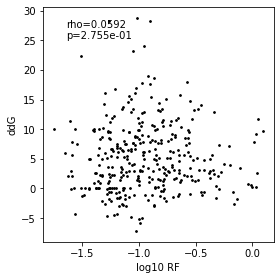

In [339]:
fig,ax = plt.subplots(figsize=(4,4))
tmpdata = rdata[rdata['mean_ddg']!=0]
plt.scatter(tmpdata['meanfit'],tmpdata['mean_ddg'],color='black',s=3)
plt.xlabel('log10 RF')
plt.ylabel('ddG')
r,p = ss.spearmanr(tmpdata['meanfit'],tmpdata['mean_ddg'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('ddG_RF_residue_mean.png',dpi=600)

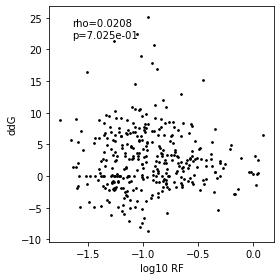

In [340]:
def calc_ddg(x):
    tmpdata = ddgdata[ddgdata['aapos']==x+16]
    if len(tmpdata) == 0: return 0
    return np.median(tmpdata['ddG'])

rdata['median_ddg'] = rdata['aapos'].apply(lambda x:calc_ddg(x))
fig,ax = plt.subplots(figsize=(4,4))
tmpdata = rdata[rdata['mean_ddg']!=0]
plt.scatter(tmpdata['meanfit'],tmpdata['median_ddg'],color='black',s=3)
plt.xlabel('log10 RF')
plt.ylabel('ddG')
r,p = ss.spearmanr(tmpdata['meanfit'],tmpdata['median_ddg'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('ddG_RF_residue_median.png',dpi=600)

## In vitro data

In [43]:
vdata = pd.read_csv('result/invitro.csv')
vdata

,Pos,Genotype,Frame1,fitOS2000_1,fitOS2000_2,fitOS2000_3,fitOS200_1,fitOS200_2,fitOS200_3,fitCTRL1,...,LOG10RF,fitOS2000_1.1,fitOS2000_2.1,fitOS2000_3.1,fitOS200_1.1,fitOS200_2.1,fitOS200_3.1,fitCTRL1.1,fitCTRL2.1,fitCTRL3.1
0,1127,G1127A,M373I,1.663683,1.004596,0.946863,0.865997,1.781682,1.521106,1.632587,...,NaN,0.2210705847,0.001991320766,-0.02371281074,-0.06248378931,0.2508301791,0.1821594288,0.212876316,0.2161479109,0.303687038
1,1127,G1127T,M373I,1.239607,1.702818,1.230390,1.411822,1.225698,1.725183,1.366285,...,NaN,0.09328400525,0.2311682003,0.09004261994,0.1497799696,0.08838344151,0.2368352908,0.1355411917,0.2306599258,0.1696213928
2,827,G827T,M273I,0.664934,0.451333,0.115266,0.801796,0.059749,0.383944,0.498542,...,NaN,-0.1772217251,-0.3455026611,-0.9382990321,-0.09593623262,-1.223667474,-0.4157325493,-0.3022980745,-0.5380075385,-0.06734401959
3,827,G827A,M273I,0.388379,0.488468,0.748499,0.607436,0.833464,0.400144,0.559545,...,NaN,-0.4107443341,-0.3111636376,-0.1258087583,-0.2164991692,-0.07911297056,-0.397783942,-0.2521647839,-0.3243721161,-0.2882775013
4,285,G285A,G93S,0.482071,0.615131,0.159418,0.390467,0.341322,0.178101,0.232871,...,NaN,-0.3168888248,-0.2110327318,-0.7974635817,-0.4084161145,-0.4668354145,-0.749333907,-0.6328854573,-0.7261228734,-0.7171958174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,381,A381C,N125H,0.000000,0.000000,0.126331,0.067606,0.071760,0.026211,0.057119,...,NaN,#NUM!,#NUM!,-0.8984901609,-1.170016307,-1.144114721,-1.581515174,-1.243217975,-1.599696825,-0.9753458166
2452,188,T188A,A60A,0.910004,0.560191,0.421085,0.840834,0.495974,0.843348,0.815293,...,NaN,-0.04095685006,-0.2516640352,-0.3756299092,-0.07528988308,-0.3045411125,-0.07399292407,-0.08868650523,-0.05352303165,0.03050214572
2453,188,T188G,A60A,0.576336,0.091668,0.335488,0.857565,0.691164,0.470375,0.730184,...,NaN,-0.2393245038,-1.037784215,-0.474323475,-0.06673279395,-0.1604190596,-0.3275560869,-0.1365676894,-0.1080741867,-0.3248076189
2454,833,G833C,V275V,0.631687,1.018321,1.204529,1.066388,0.794665,1.215821,0.157872,...,NaN,-0.1994981198,0.00788455818,0.08081725836,0.02791540835,-0.09981583282,0.08486980129,-0.8016957239,0.1024738985,0.2291383483


In [44]:
list(vdata)

['Pos',
 'Genotype',
 'Frame1',
 'fitOS2000_1',
 'fitOS2000_2',
 'fitOS2000_3',
 'fitOS200_1',
 'fitOS200_2',
 'fitOS200_3',
 'fitCTRL1',
 'fitCTRL2',
 'fitCTRL3',
 'Unnamed: 12',
 'LOG10RF',
 'fitOS2000_1.1',
 'fitOS2000_2.1',
 'fitOS2000_3.1',
 'fitOS200_1.1',
 'fitOS200_2.1',
 'fitOS200_3.1',
 'fitCTRL1.1',
 'fitCTRL2.1',
 'fitCTRL3.1']

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


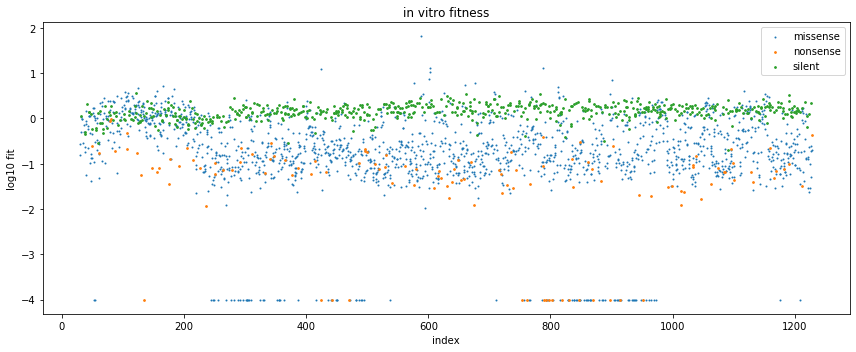

In [52]:
def find_muttype(mut):
    if mut[-1] == mut[0]:
        return 'silent'
    if mut[-1] == '_':
        return 'nonsense'
    return 'missense'

def log10fit(x):
    return np.log10(1e-4+ss.gmean([x['fitCTRL1'],x['fitCTRL2'],x['fitCTRL3']]))

vdata['mut_type'] = vdata['Frame1'].apply(lambda x:find_muttype(x))
vdata['log10fit'] = vdata.apply(lambda x:log10fit(x),axis=1)
plt.figure(figsize=(12,5))
plt.scatter(vdata[vdata['mut_type']=='missense']['Pos'],vdata[vdata['mut_type']=='missense']['log10fit'],s=1,label='missense')
plt.scatter(vdata[vdata['mut_type']=='nonsense']['Pos'],vdata[vdata['mut_type']=='nonsense']['log10fit'],s=3,label='nonsense')
plt.scatter(vdata[vdata['mut_type']=='silent']['Pos'],vdata[vdata['mut_type']=='silent']['log10fit'],s=3,label='silent')
plt.xlabel('index')
plt.ylabel('log10 fit')
plt.legend()
plt.title('in vitro fitness')
plt.tight_layout()

## dNdS analysis
Or maybe I call it pNpS because my math is not rigorous.

In [49]:
refseq = '---------------------------------------------------------------------------------AGCGAAAGC-AGG----AGT---T--TAAATGAATCCAAACCAGAAAATAATAACCATTGGGTCAATCTGTATGGTAGTCGGAATAATTAGCCTAATATTGCAAATAGGAAATATAATCTCAATATGGATTAGCCATTCAATTCAAACCGGAAATCAAAACCATA----CTGGAATATGCAACC--AAGGCAGCATTACCTA---TAAAGTTGTTGCTGGGC-------------------------------------------------------AGGACTCAACTTCAGTGATATTAACCGGCAATTCATCTCTTTGTCCCATCCGTGGGTGGGCTATACACAGCAAAGACAATGGCATAAGAATTGGTTCCAAAGGAGACGTTTTTGTCATAAGAGAGCCTTTTATTTCATGTTCTCACTTGGAATGCAGGACCTTTTTTCTGACTCAAGGCGCCTTACTGAATGACAAGCATTCAAGGGGGACCTTTAAGGACAGAAGCCCTTATAGGGCCTTAATGAGCTGCCCTGTCGGTGAAGCTCCGTCCCCGTACAATTCAAGGTTTGAATCGGTTGCTTGGTCAGCAAGTGCATGTCATGATGGAGTGGGCTGGCTAACAATCGGAATTTCTGGTCCAGATGATGGAGCAGTGGCTGTATTAAAATACAACCGCATAATAACTGAAACCATAAAAAGTTGGAGGAAGAATATATTGAGAACACAAGAGTCTGAATGTACCTGTGTAAATGGTTCATGTTTTACCATAATGACCGATGGCCCAAGTGATGGGCTGGCCTCGTACAAAATTTTCAAGATCGAGAAGGGGAAGGTTACTAAATCAATAGAGTTGAATGCACCTAATTCTCACTACGAGGAATGTTCCTGTTACCCTGATACCGGCAAAGTGATGTGTGTGTGCAGAGACAATTGGCACGGTTCGAACCGACCATGGGTGTCCTTCGACCAAAACCTAGATTATAAAATAGGATACATCTGCAGTGGGGTTTTCGGTGACAACCCGCGTCCCAAAGATGGAACAGGCAGCTGTGGCCCAGTGTCTGCTGATGGAGCAAACGGAGTAAAGGGATTTTCATATAAGTATGGCAATGGTGTTTGGATAGGAAGGACTAAAAGTGACAGTTCCAGACATGGGTTTGAGATGATTTGGGATCCTAATGGATGGACAGAGACTGATAGTAGGTTCTCTATGAGACAAGATGTTGTGGCAATAACTAATCGGTCAGGGTACAGCGGAAGTTTCGTTCAACATCCTGAGCTAACAGGGCTAGACTGTATGAGGCCTTGCTTCTGGGTTGAATTAATCAGGGGGCTACCTGAGGAGGA----CGCAATCTGGACTAGTGGGAGCATCATTTCTTTTTGTGGTGTGAATAGTGATACTGTAGATTGGTCTTGGCCAGACGGTGCTGAGTTGCCGTTCACCATTGACAAGTAG-TTTGTTC---AAA------AAA---CTCCTTGTTTCTACT--------------------'
refseq = refseq[110:-61]
reforfseq = refseq.replace('-','')
lencodon = int(len(reforfseq)/3)+1
print(lencodon)

455


In [40]:
#consensus
reffile = open('result/aligned_WSN_database_DNA.fasta') 
seqlist = []
for record in SeqIO.parse(reffile,'fasta'):
    seqlist.append(str(record.seq)[110:-61])
reffile.close()
cnsseq = ''
for i in range(len(seqlist[0])):
    nuclist = []
    for seq in seqlist:
        nuclist.append(seq[i])
    cnsseq += Counter(nuclist).most_common(1)[0][0]
print(cnsseq)

ATGAATCCAAACCAAAAGATAATAACCATTGGTTCGATCTGTATGACAATTGGAATGGCTAACTTAATATTACAAATTGGAAACATAATCTCAATATGGGTTAGCCACTCAATTCAAATTGGAAATCAAAGCCAGA----TTGAAACATGCAATC--AAAGCGTCATTACTTATG--AAAACAACACTTGGGTAA--------ATCAGACATATGTTAACATCAGCAACACCAACTTTGCTGCTGGACAGTCAGTGGTTTCCGTGAAATTAGCGGGCAATTCCTCTCTCTGCCCTGTTAGTGGATGGGCTATATACAGTAAAGACAACAGTGTAAGAATCGGTTCCAAGGGGGATGTGTTTGTCATAAGGGAACCATTCATATCATGCTCTCCCTTGGAATGCAGAACCTTCTTCTTGACTCAAGGGGCCTTGCTAAATGACAAACATTCCAATGGAACCATTAAAGACAGGAGCCCATATCGAACCCTAATGAGCTGTCCTATTGGTGAAGTTCCCTCTCCATACAACTCAAGATTTGAGTCAGTCGCTTGGTCAGCAAGTGCTTGTCATGATGGCATCAATTGGCTAACAATTGGAATTTCTGGCCCAGACAGTGGGGCAGTGGCTGTGTTAAAGTACAATGGCATAATAACAGACACTATCAAGAGTTGGAGGAACAATATATTGAGAACACAAGAGTCTGAATGTGCATGTGTAAATGGTTCTTGCTTTACCATAATGACCGATGGACCAAGTGATGGACAGGCCTCATACAAAATCTTCAGAATAGAAAAGGGAAAGATAATCAAATCAGTCGAAATGAAAGCCCCTAATTATCACTATGAGGAATGCTCCTGTTACCCTGATTCTAGTGAAATCACATGTGTGTGCAGGGATAACTGGCATGGCTCGAATCGACCGTGGGTGTCTTTCAACCAGAATCTGGAATATCAGATAGGATACATATGCAGTGGGGTTTTCGGAGACAATCCACGCCCT

In [53]:
dndict = {}
dsdict = {}
for codoni in range(lencodon):
    dndict[codoni] = 0
    dsdict[codoni] = 0

reffile = open('result/aligned_WSN_database_DNA.fasta') 
count = 0; goodcount = 0
for record in SeqIO.parse(reffile,'fasta'):
    if count % 10000 == 0:
        print('reading reference count: '+str(count)+'\nGood sequence: '+str(goodcount))
    #if count >= 1000: break
    count += 1
    seq = str(record.seq)[110:-61]
    _badread = 0
    codoni = 0; dslist = []; dnlist = []
    refcodon = ''; querycodon = ''; cnscodon = ''
    for nuci, refnuc in enumerate(refseq):
        if refnuc == '-': continue
        refcodon += refnuc
        querycodon += seq[nuci]
        cnscodon += cnsseq[nuci]
        if len(refcodon) % 3 == 0:
            codoni += 1
            if cnscodon != querycodon:
                try:
                    queryaa = Seq(querycodon).translate()
                    cnsaa   = Seq(cnscodon).translate()
                except:
                    _badread = 1
                    continue
                if queryaa == cnsaa:
                    dslist.append(codoni)
                else:
                    dnlist.append(codoni)
            refcodon = ''; querycodon = ''; cnscodon = ''
    if _badread == 0 or _badread == 1:
        for codoni in dslist:
            dsdict[codoni] += 1
        for codoni in dnlist:
            dndict[codoni] += 1
        goodcount += 1
print('Total reference count: '+str(count)+'\nGood sequence: '+str(goodcount))
reffile.close()

reading reference count: 0
Good sequence: 0
reading reference count: 10000
Good sequence: 10000
Total reference count: 13310
Good sequence: 13310


In [59]:
window = 20

def calc_dndsnorm(codonseq):
    dn = 0; ds = 0; oldaa = codonseq.translate()
    for i,nuc in enumerate(codonseq):
        for newnuc in list('ATCG'):
            if newnuc != nuc:
                newcodon = codonseq[:i]+newnuc+codonseq[i+1:]
                newaa = newcodon.translate()
                if newaa != oldaa:
                    dn += 1
                else:
                    ds += 1
    return dn,ds

dndsdict = {}
for codon in range(lencodon-window):
    if codon in dsdict:
        dn = 0; ds = 0
        for w in range(window):
            dn += dndict[codon+w]
            ds += dsdict[codon+w]
        if ds == 0: continue
        dnds = dn/ds
        codonseq = Seq(reforfseq[codon*3:(codon+window)*3])
        normdn,normds = calc_dndsnorm(codonseq)
        normdnds = normdn/normds
        dndsdict[codon] = dnds/normdnds

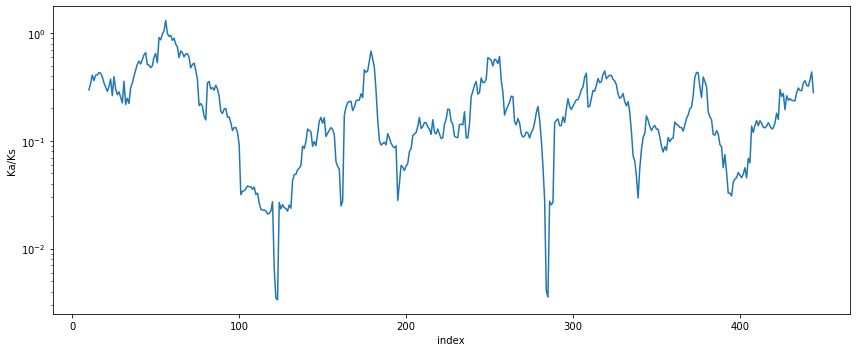

In [67]:
plt.figure(figsize=(12,5))
plt.plot([x+window/2 for x in list(dndsdict.keys())],list(dndsdict.values()))
plt.ylabel('Ka/Ks')
plt.xlabel('index')
plt.yscale('log')
plt.tight_layout()
plt.savefig('dnds.png',dpi=600)

In [63]:
dndsdict

{0: 0.29729301097882704,
 1: 0.3408337598401209,
 2: 0.4068605307735743,
 3: 0.3619933172236157,
 4: 0.4060214894679415,
 5: 0.4090603951755466,
 6: 0.4290268702387403,
 7: 0.42491753249318537,
 8: 0.39375832190565635,
 9: 0.34612278886673903,
 10: 0.31643725394407884,
 11: 0.2881602781272349,
 12: 0.3184335029921831,
 13: 0.3744370377134508,
 14: 0.26329232053832363,
 15: 0.39375689651242096,
 16: 0.3035023593395158,
 17: 0.2681415857801015,
 18: 0.2848386647235417,
 19: 0.2544556063131915,
 20: 0.22516452165917208,
 21: 0.3569127863259374,
 22: 0.21758876393220294,
 23: 0.2487690869429729,
 24: 0.22243550335541615,
 25: 0.3118620689655172,
 26: 0.3436201032875677,
 27: 0.39769864506025737,
 28: 0.45356938745368497,
 29: 0.5136554621848739,
 30: 0.5504536418396783,
 31: 0.5164758237911896,
 32: 0.5660676640578038,
 33: 0.6276917048468772,
 34: 0.6582076666456094,
 35: 0.5096013531531501,
 36: 0.5050630975724028,
 37: 0.47795231142495803,
 38: 0.4972244094488189,
 39: 0.601159127915478